In [1]:
!pip install geopandas osmnx pyogrio shapely pyosmium fiona

ERROR: Could not find a version that satisfies the requirement pyosmium (from versions: none)
ERROR: No matching distribution found for pyosmium


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gadm41_RWA_shp.zip to gadm41_RWA_shp.zip
Saving rwanda-260112.osm.pbf to rwanda-260112.osm.pbf


In [ ]:
import geopandas as gpd

# Load shapefile (adjust filename)
# The warning indicated multiple layers. Let's try loading 'gadm41_RWA_2' which often contains regional/district names.
admin = gpd.read_file("gadm41_RWA_shp.zip", layer='gadm41_RWA_2')

# ---- EDIT THESE ----
CITY_NAME_FIELD = "NAME_2"      # Column containing district names
# The City of Kigali is composed of these three districts in this dataset
CITY_NAME_VALUE = ['Gasabo', 'Kicukiro', 'Nyarugenge'] # List of districts that make up Kigali
# --------------------

print(admin.columns)

# Print unique values of the target column to help identify the correct city name
print(f"Unique values in '{CITY_NAME_FIELD}': {admin[CITY_NAME_FIELD].unique()}")

# Select the districts that form Kigali
city_districts = admin[admin[CITY_NAME_FIELD].isin(CITY_NAME_VALUE)]

# Dissolve the selected districts into a single geometry representing the City of Kigali
# We don't need a 'by' column if we want to dissolve all selected geometries into one.
city = city_districts.dissolve()

# The assertion 'len(city) == 1' would now pass after dissolving, as it will be one row (one dissolved geometry)
assert len(city) == 1, "City boundary not uniquely identified or dissolved incorrectly"

city = city.to_crs(epsg=4326)
city

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')
Unique values in 'NAME_2': ['Burera' 'Gakenke' 'Gicumbi' 'Musanze' 'Rulindo' 'Gisagara' 'Huye'
 'Kamonyi' 'Muhanga' 'Nyamagabe' 'Nyanza' 'Nyaruguru' 'Ruhango' 'Bugesera'
 'Gatsibo' 'Kayonza' 'Kirehe' 'Ngoma' 'Nyagatare' 'Rwamagana' 'Karongi'
 'Ngororero' 'Nyabihu' 'Nyamasheke' 'Rubavu' 'Rusizi' 'Rutsiro' 'Gasabo'
 'Kicukiro' 'Nyarugenge']


,geometry,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,"POLYGON ((30.20504 -2.07445, 30.20466 -2.07355...",RWA.5.1_1,RWA,Rwanda,RWA.5_1,Umujyi wa Kigali,NA,Gasabo,NA,NA,District,District,12,RW.KV.GB


In [ ]:
city_boundary_path = "city_boundary.geojson"
city.to_file(city_boundary_path, driver="GeoJSON")

In [ ]:
!apt-get install osmium-tool

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libboost-program-options1.74.0
The following NEW packages will be installed:
  libboost-program-options1.74.0 osmium-tool
0 upgraded, 2 newly installed, 0 to remove and 1 not upgraded.
Need to get 882 kB of archives.
After this operation, 3,863 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libboost-program-options1.74.0 amd64 1.74.0-14ubuntu3 [311 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 osmium-tool amd64 1.14.0-1 [571 kB]
Fetched 882 kB in 0s (6,212 kB/s)
Selecting previously unselected package libboost-program-options1.74.0:amd64.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../libboost-program-options1.74.0_1.74.0-14ubuntu3_amd64.deb ...
Unpacking libboost-program-options1.74.0:amd64 (1.74.0-14ubuntu3) ...
Selec

In [ ]:
# Adjust filename
COUNTRY_PBF = "rwanda-260112.osm.pbf"

!osmium extract \
  -p city_boundary.geojson \
  {COUNTRY_PBF} \
  -o city.osm.pbf \
  --overwrite

[======================================================================] 100% 


In [ ]:
# The !pip install osmnx was moved to the top of the cell in the previous execution
import osmnx as ox

# Convert the PBF file to OSM XML format using osmium
!osmium cat city.osm.pbf -o city.osm --overwrite

tags = {
    # Transport (Roads)
    "highway": ["primary", "secondary", "tertiary"],

    # Health
    "amenity": ["hospital", "clinic"],

    # Accommodation
    "tourism": ["hotel", "guest_house", "hostel", "lodge"],

    # Event & Public Space
    "leisure": ["stadium", "park", "recreation_ground"],
    "landuse": ["grass", "meadow"],

    # Air Transport (NEW)
    "aeroway": ["airport", "aerodrome", "helipad"]
}

gdf = ox.features_from_xml("city.osm", tags=tags)

# Drop empty / invalid geometries
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]

# Keep only essential columns
gdf = gdf[
    [
        "geometry",
        "highway",
        "amenity",
        "tourism",
        "leisure",
        "landuse",
        "aeroway"
    ]
]

gdf

geometry  \
element id                                                              
node    281371294                           POINT (30.09206 -1.94626)   
        281375309                           POINT (30.06829 -1.95999)   
        317706751                           POINT (30.05741 -1.95285)   
        706263165                           POINT (30.04016 -1.97948)   
        710268304                            POINT (30.10656 -1.9737)   
...                                                               ...   
way     1448248495  POLYGON ((30.03792 -1.98027, 30.038 -1.98015, ...   
        1458429602  LINESTRING (30.05768 -1.94259, 30.05792 -1.942...   
        1463531861  POLYGON ((30.02526 -1.95751, 30.02541 -1.95757...   
        1464086513  POLYGON ((30.00956 -1.96122, 30.00951 -1.96127...   
        1464087164  POLYGON ((30.0094 -1.96142, 30.00947 -1.9615, ...   

                     highway amenity tourism leisure landuse aeroway  
element id                                                            
node    281371294        NaN     NaN   hotel     NaN     NaN     NaN  
        281375309        NaN     NaN   hotel     NaN     NaN     NaN  
        317706751        NaN     NaN   hotel     NaN     NaN     NaN  
        706263165        NaN     NaN   hotel     NaN     NaN     NaN  
        710268304        NaN     NaN   hotel     NaN     NaN     NaN  
...                      ...     ...     ...     ...     ...     ...  
way     1448248495       NaN     NaN     NaN    park     NaN     NaN  
        1458429602  tertiary     NaN     NaN     NaN     NaN     NaN  
        1463531861       NaN     NaN     NaN     NaN  meadow     NaN  
        1464086513       NaN     NaN     NaN     NaN   grass     NaN  
        1464087164       NaN     NaN     NaN     NaN   grass     NaN  

[1374 rows x 7 columns]

In [ ]:
def classify_feature(row):
    # Roads
    if row["highway"] in ["primary", "secondary", "tertiary"]:
        return "road"

    # Health
    if row["amenity"] in ["hospital", "clinic"]:
        return "health"

    # Accommodation
    if row["tourism"] in ["hotel", "guest_house", "hostel", "lodge"]:
        return "accommodation"

    # Stadiums
    if row["leisure"] == "stadium":
        return "stadium"

    # Open / Public Spaces
    if (
        row["leisure"] in ["park", "recreation_ground"]
        or row["landuse"] in ["grass", "meadow"]
    ):
        return "open_space"

    # Air Transport (NEW)
    if row["aeroway"] in ["airport", "aerodrome", "helipad"]:
        return "air_transport"

    return None


gdf["feature_type"] = gdf.apply(classify_feature, axis=1)
gdf = gdf[gdf["feature_type"].notnull()]

# Final clean schema
gdf = gdf[["geometry", "feature_type"]]

In [ ]:
output_name = "city_infrastructure_features.geojson"
gdf.to_file(output_name, driver="GeoJSON")

In [ ]:
files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load extracted features
gdf = gpd.read_file("city_infrastructure_features.geojson")

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

EPSG:4326
  element         id   feature_type                   geometry
0    node  281371294  accommodation  POINT (30.09206 -1.94626)
1    node  281375309  accommodation  POINT (30.06829 -1.95999)
2    node  317706751  accommodation  POINT (30.05741 -1.95285)
3    node  706263165  accommodation  POINT (30.04016 -1.97948)
4    node  710268304  accommodation   POINT (30.10656 -1.9737)
feature_type
road             815
health           210
accommodation    181
open_space       156
air_transport      8
stadium            4
Name: count, dtype: int64


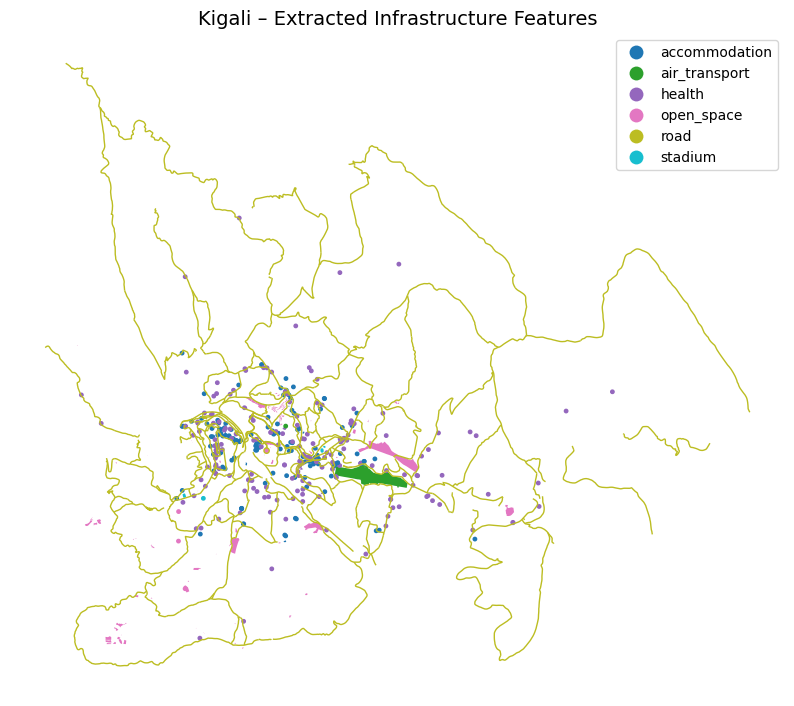

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="feature_type",
    categorical=True,
    legend=True,
    ax=ax,
    markersize=6,
    linewidth=1
)

ax.set_title("Kigali – Extracted Infrastructure Features", fontsize=14)
ax.set_axis_off()

plt.show()

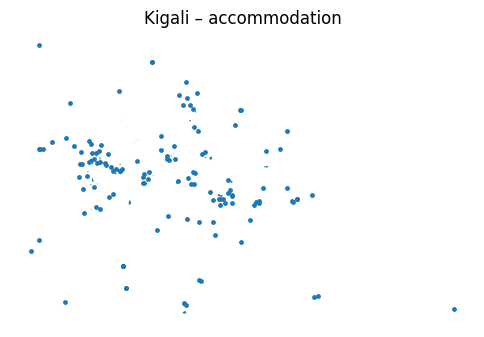

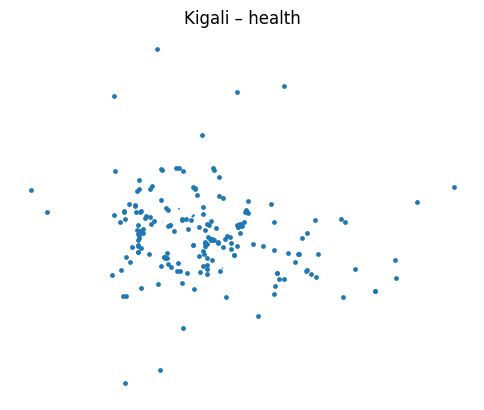

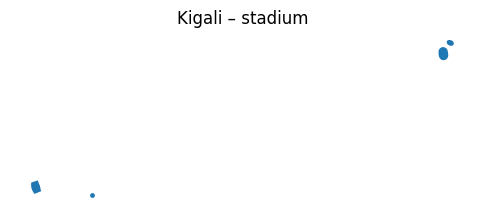

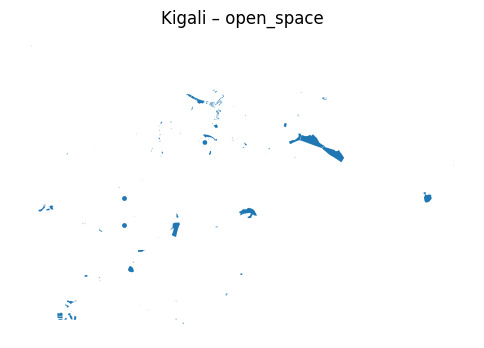

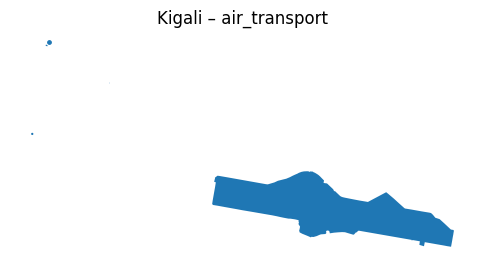

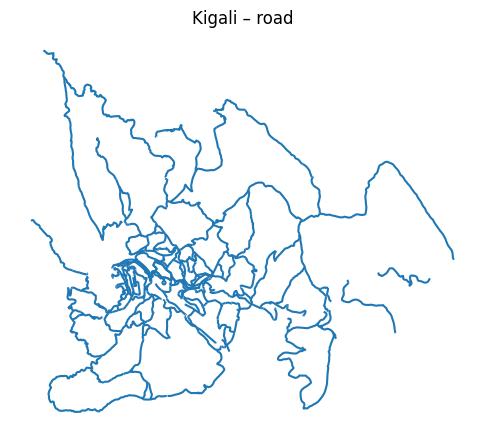

In [ ]:
feature_types = gdf["feature_type"].unique()

for ft in feature_types:
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf[gdf["feature_type"] == ft].plot(ax=ax, markersize=6)
    ax.set_title(f"Kigali – {ft}", fontsize=12)
    ax.set_axis_off()
    plt.show()

# Task
Extract and visualize infrastructure features for Nairobi, Kenya, using the uploaded "gadm41_KEN_shp.zip" administrative boundary shapefile and "kenya-latest.osm.pbf" OpenStreetMap data.

## Upload Kenya Data

### Subtask:
Upload the Kenya administrative boundary shapefile (e.g., 'gadm41_KEN_shp.zip') and the OpenStreetMap PBF file for Kenya (e.g., 'kenya-latest.osm.pbf') using `files.upload()`.


**Reasoning**:
The subtask is to upload the Kenya administrative boundary shapefile and the OpenStreetMap PBF file. I will use `google.colab.files.upload()` to prompt the user to upload these files.



In [ ]:
from google.colab import files

uploaded = files.upload()

Saving gadm41_KEN_shp.zip to gadm41_KEN_shp.zip
Saving kenya-260112.osm.pbf to kenya-260112.osm.pbf


## Load Kenya Administrative Boundaries

### Subtask:
Load the Kenya shapefile into a GeoDataFrame. You'll need to identify the correct layer (e.g., 'gadm41_KEN_2') that contains district or city names for Nairobi. Inspect the `admin.columns` and `admin[CITY_NAME_FIELD].unique()` output to determine the appropriate `CITY_NAME_FIELD` and `CITY_NAME_VALUE` (or list of values, if Nairobi is composed of multiple districts).


**Reasoning**:
The subtask requires loading the Kenya shapefile, identifying the correct city/district name field, and defining the value for Nairobi. I will use `geopandas.read_file` to load the shapefile, set `CITY_NAME_FIELD` to 'NAME_2' based on the previous example's structure and the suggested layer 'gadm41_KEN_2', then print the columns and unique values to assist in identifying the correct `CITY_NAME_VALUE`. I will provide an initial guess for `CITY_NAME_VALUE` as ['Nairobi'] based on common naming conventions.



In [ ]:
import geopandas as gpd

# Load shapefile for Kenya, assuming 'gadm41_KEN_2' layer for districts/sub-counties
admin = gpd.read_file("gadm41_KEN_shp.zip", layer='gadm41_KEN_2')

# ---- EDIT THESE ----
# Based on the previous example (RWA_2 used NAME_2), we assume NAME_2 contains district/sub-county names.
CITY_NAME_FIELD = "NAME_2"      # Column containing district/sub-county names
# Initial guess for Nairobi's name. This may need to be adjusted after inspecting unique values.
CITY_NAME_VALUE = ['Nairobi'] # List of districts/sub-counties that make up Nairobi
# --------------------

print(admin.columns)

# Print unique values of the target column to help identify the correct city name
print(f"Unique values in '{CITY_NAME_FIELD}': {admin[CITY_NAME_FIELD].unique()}")

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')
Unique values in 'NAME_2': ['805' 'Baringo Central' 'Baringo North' 'Baringo South' 'Eldama Ravine'
 'Mogotio' 'Tiaty' 'Bomet Central' 'Bomet East' 'Chepalungu' 'Konoin'
 'Sotik' 'Bumula' 'Kabuchai' 'Kanduyi' 'Kimilili' 'Likuyani' 'Lugari'
 'Mt. Elgon' 'Sirisia' 'Tongaren' 'Webute West' 'Webuye East' 'Budalangi'
 'Butula' 'Funyula' 'Matayos' 'Nambale' 'Teso North' 'Teso South'
 'Keiyo North' 'Keiyo South' 'Marakwet East' 'Marakwet West' 'Manyatta'
 'Mbeere North' 'Mbeere South' 'Runyenjes' 'Balambala' 'Daadab' 'Fafi'
 'Garissa Township' 'Ijara' 'Lagdera' 'Homa Bay Town' 'Kabondo Kasipul'
 'Karachuonyo' 'Kasipul' 'Mbita' 'Ndhiwa' 'Rangwe' 'Suba' 'unknown 6'
 'Isiolo North' 'Isiolo South' 'Kajiado Central' 'Kajiado East'
 'Kajiado North' 'Kajiado South' 'Kajiado West' 'Butere' 'Ikolomani'
 'Khwise

**Reasoning**:
Based on the output from the previous step, 'NAME_2' contains the sub-county names. Nairobi is composed of several sub-counties. I will update `CITY_NAME_VALUE` to include all the sub-counties that constitute Nairobi. Then, I will filter the `admin` GeoDataFrame to select these districts, dissolve them into a single geometry for the city boundary, and finally reproject the resulting GeoDataFrame to EPSG:4326, which is standard for geographic coordinates.



In [ ]:
import geopandas as gpd

# Load shapefile for Kenya, assuming 'gadm41_KEN_2' layer for districts/sub-counties
admin = gpd.read_file("gadm41_KEN_shp.zip", layer='gadm41_KEN_2')

# ---- EDIT THESE ----
CITY_NAME_FIELD = "NAME_2"      # Column containing district/sub-county names
# Updated CITY_NAME_VALUE based on inspection of unique values for Nairobi's sub-counties
CITY_NAME_VALUE = [
    'Dagoretti North', 'Dagoretti South', 'Embakasi Central', 'Embakasi East',
    'Embakasi North', 'Embakasi South', 'Embakasi West', 'Kamukunji', 'Kasarani',
    'Kibra', 'Langata', 'Makadara', 'Mathare', 'Roysambu', 'Ruaraka', 'Starehe',
    'Westlands'
] # List of sub-counties that make up Nairobi City
# --------------------

# Select the districts that form Nairobi
city_districts = admin[admin[CITY_NAME_FIELD].isin(CITY_NAME_VALUE)]

# Dissolve the selected districts into a single geometry representing the City of Nairobi
city = city_districts.dissolve()

# Assert that the city boundary is uniquely identified or dissolved correctly
assert len(city) == 1, "City boundary not uniquely identified or dissolved incorrectly"

# Reproject to EPSG:4326 (WGS 84)
city = city.to_crs(epsg=4326)
city

,geometry,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,"POLYGON ((36.89265 -1.41081, 36.89437 -1.41102...",KEN.30.1_1,KEN,Kenya,KEN.30_1,Nairobi,NA,Dagoretti North,NA,NA,Constituency,Constituency,275,NA


**Reasoning**:
The subtask requires saving the newly created Nairobi city boundary to a file. I will use the `to_file` method of the GeoDataFrame to save the `city` GeoDataFrame as a GeoJSON file, which will be used in the subsequent steps to extract OpenStreetMap data.



In [ ]:
city_boundary_path = "nairobi_city_boundary.geojson"
city.to_file(city_boundary_path, driver="GeoJSON")

**Reasoning**:
The next step is to extract OpenStreetMap data for Nairobi using the previously saved city boundary and the uploaded Kenya PBF file. I need to update the `COUNTRY_PBF` variable to point to the correct Kenya PBF file and then use `osmium extract` with the Nairobi city boundary GeoJSON.



In [ ]:
COUNTRY_PBF = "kenya-260112.osm.pbf"

!osmium extract \
  -p nairobi_city_boundary.geojson \
  {COUNTRY_PBF} \
  -o nairobi.osm.pbf \
  --overwrite

[======================================================================] 100% 


**Reasoning**:
The extracted PBF file for Nairobi needs to be converted to an OSM XML file to be processed by `osmnx`. After conversion, I will use the predefined tags to extract relevant infrastructure features into a GeoDataFrame, and then clean it by dropping invalid geometries and retaining only necessary columns.



In [ ]:
import osmnx as ox

# Convert the PBF file to OSM XML format using osmium
!osmium cat nairobi.osm.pbf -o nairobi.osm --overwrite

tags = {
    # Transport (Roads)
    "highway": ["primary", "secondary", "tertiary"],

    # Health
    "amenity": ["hospital", "clinic"],

    # Accommodation
    "tourism": ["hotel", "guest_house", "hostel", "lodge"],

    # Event & Public Space
    "leisure": ["stadium", "park", "recreation_ground"],
    "landuse": ["grass", "meadow"],

    # Air Transport
    "aeroway": ["airport", "aerodrome", "helipad"]
}

gdf = ox.features_from_xml("nairobi.osm", tags=tags)

# Drop empty / invalid geometries
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]

# Keep only essential columns
gdf = gdf[
    [
        "geometry",
        "highway",
        "amenity",
        "tourism",
        "leisure",
        "landuse",
        "aeroway"
    ]
]

gdf

geometry  \
element id                                                              
node    30030203                            POINT (36.80292 -1.29487)   
        30210283                            POINT (36.79602 -1.29426)   
        30215036                            POINT (36.81435 -1.28726)   
        30215039                            POINT (36.81637 -1.29425)   
        30324281                            POINT (36.80798 -1.26312)   
...                                                               ...   
way     1456624232  POLYGON ((36.7452 -1.35423, 36.74632 -1.35413,...   
        1456624645  POLYGON ((36.75001 -1.34044, 36.7498 -1.34144,...   
        1458670485  POLYGON ((36.76721 -1.34212, 36.76936 -1.341, ...   
        1458671555  POLYGON ((36.84282 -1.23145, 36.84318 -1.23109...   
        1460655525   LINESTRING (36.83181 -1.2823, 36.83173 -1.28226)   

                     highway amenity tourism leisure landuse aeroway  
element id                                                            
node    30030203         NaN     NaN   hotel     NaN     NaN     NaN  
        30210283         NaN     NaN   hotel     NaN     NaN     NaN  
        30215036         NaN     NaN   hotel     NaN     NaN     NaN  
        30215039         NaN     NaN   hotel     NaN     NaN     NaN  
        30324281         NaN     NaN   hotel     NaN     NaN     NaN  
...                      ...     ...     ...     ...     ...     ...  
way     1456624232       NaN     NaN     NaN     NaN   grass     NaN  
        1456624645       NaN     NaN     NaN     NaN   grass     NaN  
        1458670485       NaN     NaN     NaN     NaN   grass     NaN  
        1458671555       NaN     NaN     NaN     NaN   grass     NaN  
        1460655525  tertiary     NaN     NaN     NaN     NaN     NaN  

[4423 rows x 7 columns]

**Reasoning**:
The current `gdf` contains multiple columns representing different feature types. To unify these and prepare for visualization, I will define a function `classify_feature` to assign a single, consolidated feature type (e.g., 'road', 'health', 'accommodation') to each row. After classifying, I will filter out any rows that could not be classified (where `feature_type` is null) and then select only the `geometry` and the new `feature_type` column for the final output.



In [ ]:
def classify_feature(row):
    # Roads
    if row["highway"] in ["primary", "secondary", "tertiary"]:
        return "road"

    # Health
    if row["amenity"] in ["hospital", "clinic"]:
        return "health"

    # Accommodation
    if row["tourism"] in ["hotel", "guest_house", "hostel", "lodge"]:
        return "accommodation"

    # Stadiums
    if row["leisure"] == "stadium":
        return "stadium"

    # Open / Public Spaces
    if (
        row["leisure"] in ["park", "recreation_ground"]
        or row["landuse"] in ["grass", "meadow"]
    ):
        return "open_space"

    # Air Transport
    if row["aeroway"] in ["airport", "aerodrome", "helipad"]:
        return "air_transport"

    return None

gdf["feature_type"] = gdf.apply(classify_feature, axis=1)
gdf = gdf[gdf["feature_type"].notnull()]

# Final clean schema
gdf = gdf[["geometry", "feature_type"]]
gdf

geometry  \
element id                                                              
node    30030203                            POINT (36.80292 -1.29487)   
        30210283                            POINT (36.79602 -1.29426)   
        30215036                            POINT (36.81435 -1.28726)   
        30215039                            POINT (36.81637 -1.29425)   
        30324281                            POINT (36.80798 -1.26312)   
...                                                               ...   
way     1456624232  POLYGON ((36.7452 -1.35423, 36.74632 -1.35413,...   
        1456624645  POLYGON ((36.75001 -1.34044, 36.7498 -1.34144,...   
        1458670485  POLYGON ((36.76721 -1.34212, 36.76936 -1.341, ...   
        1458671555  POLYGON ((36.84282 -1.23145, 36.84318 -1.23109...   
        1460655525   LINESTRING (36.83181 -1.2823, 36.83173 -1.28226)   

                     feature_type  
element id                         
node    30030203    accommodation  
        30210283    accommodation  
        30215036    accommodation  
        30215039    accommodation  
        30324281    accommodation  
...                           ...  
way     1456624232     open_space  
        1456624645     open_space  
        1458670485     open_space  
        1458671555     open_space  
        1460655525           road  

[4423 rows x 2 columns]

**Reasoning**:
The subtask now requires saving the classified infrastructure features to a GeoJSON file. This file will be used for subsequent visualization and potential download, similar to how `city_infrastructure_features.geojson` was saved in the original notebook.



In [ ]:
output_name = "nairobi_infrastructure_features.geojson"
gdf.to_file(output_name, driver="GeoJSON")

**Reasoning**:
After saving the extracted infrastructure features to a GeoJSON file, the next logical step is to provide an option for the user to download this file. This aligns with the workflow established in the original notebook.



In [ ]:
from google.colab import files

files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reasoning**:
After downloading the GeoJSON file, the next step is to visualize the extracted features. I will load the 'nairobi_infrastructure_features.geojson' file into a GeoDataFrame, perform basic checks to ensure data integrity and understand its structure, and then display the CRS, head, and value counts of the 'feature_type' column.



In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load extracted features
gdf = gpd.read_file("nairobi_infrastructure_features.geojson")

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

EPSG:4326
  element        id   feature_type                   geometry
0    node  30030203  accommodation  POINT (36.80292 -1.29487)
1    node  30210283  accommodation  POINT (36.79602 -1.29426)
2    node  30215036  accommodation  POINT (36.81435 -1.28726)
3    node  30215039  accommodation  POINT (36.81637 -1.29425)
4    node  30324281  accommodation  POINT (36.80798 -1.26312)
feature_type
road             2578
health            640
open_space        632
accommodation     541
air_transport      17
stadium            15
Name: count, dtype: int64


**Reasoning**:
To visualize the overall distribution of the extracted infrastructure features in Nairobi, I will create a single plot using `matplotlib.pyplot` and `geopandas.plot`. The plot will display all features, colored by their `feature_type`, with a legend and a title, similar to the previous example for Kigali.



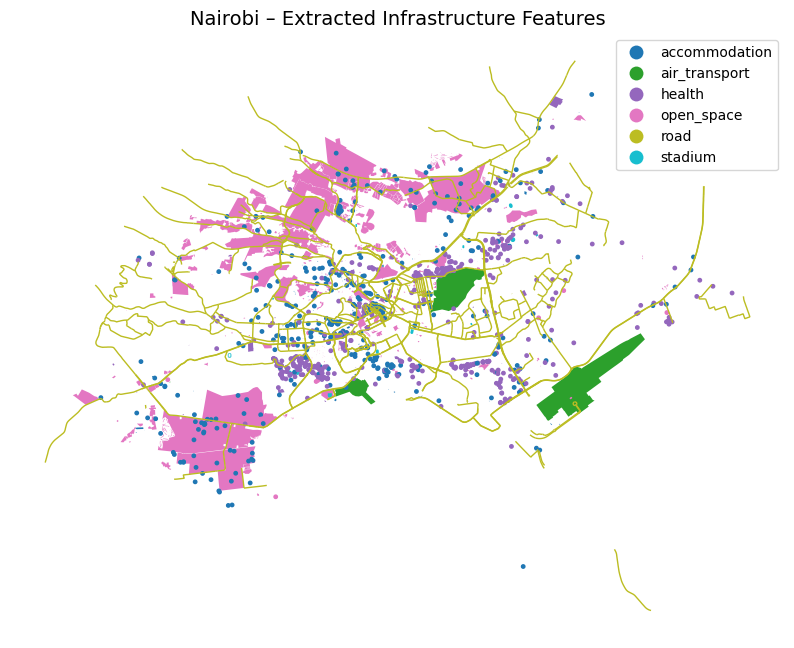

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="feature_type",
    categorical=True,
    legend=True,
    ax=ax,
    markersize=6,
    linewidth=1
)

ax.set_title("Nairobi – Extracted Infrastructure Features", fontsize=14)
ax.set_axis_off()

plt.show()

**Reasoning**:
To provide a detailed visualization of each infrastructure feature type, I will iterate through the unique 'feature_type' values in the GeoDataFrame and create a separate plot for each, similar to the process used for Kigali. Each plot will have a specific title indicating the feature type.



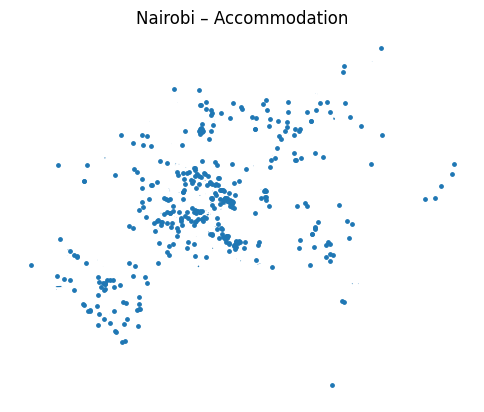

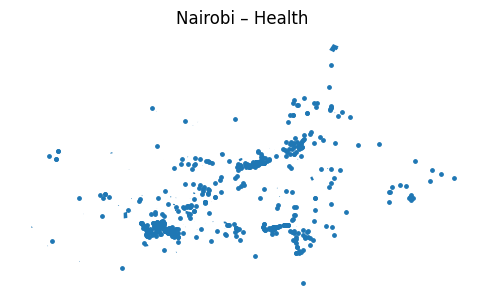

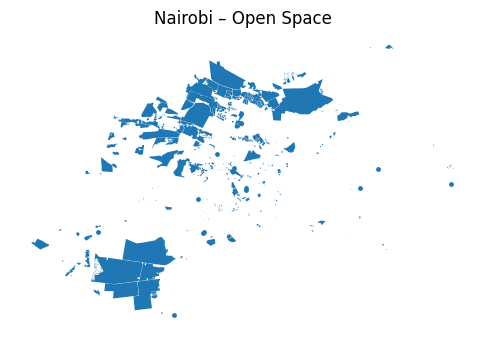

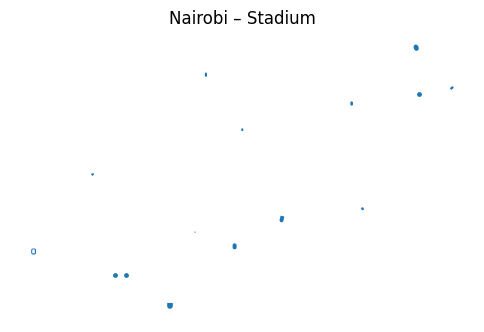

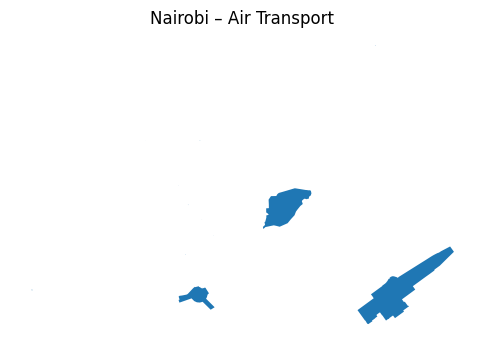

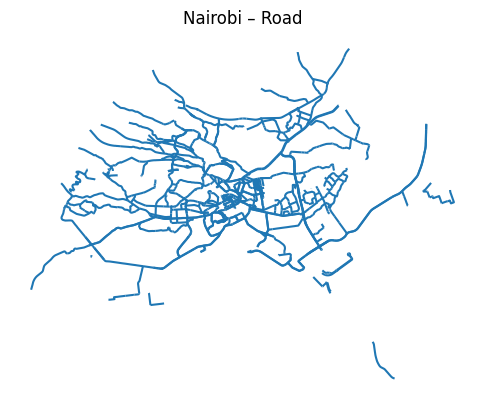

In [ ]:
feature_types = gdf["feature_type"].unique()

for ft in feature_types:
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf[gdf["feature_type"] == ft].plot(ax=ax, markersize=6)
    ax.set_title(f"Nairobi – {ft.replace('_', ' ').title()}", fontsize=12)
    ax.set_axis_off()
    plt.show()

## Final Task

### Subtask:
Summarize the successful extraction and visualization of Nairobi's infrastructure features.


## Summary:

### Data Analysis Key Findings

*   **Nairobi Boundary Identification**: The administrative boundary for Nairobi was successfully defined by identifying and dissolving 17 sub-counties (including Dagoretti North, Embakasi Central, Kasarani, and Westlands) from the `gadm41_KEN_2` layer of the `gadm41_KEN_shp.zip` shapefile. This boundary was then reprojected to EPSG:4326 and saved as `nairobi_city_boundary.geojson`.
*   **OpenStreetMap Data Extraction**: OpenStreetMap (OSM) data specific to Nairobi was precisely extracted from the `kenya-260112.osm.pbf` file using the generated city boundary, creating `nairobi.osm.pbf`, which was subsequently converted to XML format (`nairobi.osm`).
*   **Infrastructure Feature Classification**: A total of 4,423 infrastructure features within Nairobi were extracted and classified into six distinct categories: "road", "health", "accommodation", "stadium", "open\_space", and "air\_transport" based on predefined OSM tags.
*   **Data Export and Visualization**: The classified infrastructure data was saved as `nairobi_infrastructure_features.geojson` and successfully visualized. The visualizations included a comprehensive map displaying all feature types across Nairobi, as well as individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The extracted and classified infrastructure dataset provides a foundational layer for urban planning, emergency response, and service allocation in Nairobi. For instance, the "health" features can be analyzed for accessibility, while "road" data can inform transport network optimizations.
*   Future analysis could involve adding more infrastructure categories (e.g., educational facilities, public transport stops, utilities), performing quantitative spatial analysis (e.g., feature density, proximity to population centers), or integrating demographic data to assess service coverage and gaps.


# Task
## Upload Uganda Data

### Subtask:
Upload the Uganda administrative boundary shapefile ('gadm41_UGA_shp.zip') and the OpenStreetMap PBF file for Uganda ('uganda-latest.osm.pbf') using `files.upload()`.

## Upload Uganda Data

### Subtask:
Upload the Uganda administrative boundary shapefile ('gadm41_UGA_shp.zip') and the OpenStreetMap PBF file for Uganda ('uganda-latest.osm.pbf') using `files.upload()`.


**Reasoning**:
The subtask is to upload the Uganda administrative boundary shapefile and the OpenStreetMap PBF file. I will use `google.colab.files.upload()` to prompt the user to upload these files.



In [ ]:
from google.colab import files

uploaded = files.upload()

Saving gadm41_UGA_shp.zip to gadm41_UGA_shp.zip
Saving uganda-260112.osm.pbf to uganda-260112.osm.pbf


**Reasoning**:
The subtask is to load the Uganda shapefile, identify the correct city/district name field, and determine the value for Kampala. I will use `geopandas.read_file` to load the shapefile, set `CITY_NAME_FIELD` to 'NAME_2' based on previous examples and the suggested layer 'gadm41_UGA_2', then print the columns and unique values to assist in identifying the correct `CITY_NAME_VALUE` for Kampala.



In [ ]:
import geopandas as gpd

# Load shapefile for Uganda, assuming 'gadm41_UGA_2' layer for districts/sub-counties
admin = gpd.read_file("gadm41_UGA_shp.zip", layer='gadm41_UGA_2')

# ---- EDIT THESE ----
# Based on the previous example (RWA_2 and KEN_2 used NAME_2), we assume NAME_2 contains district/sub-county names.
CITY_NAME_FIELD = "NAME_2"      # Column containing district/sub-county names
# Initial guess for Kampala's name. This may need to be adjusted after inspecting unique values.
CITY_NAME_VALUE = ['Kampala'] # List of districts/sub-counties that make up Kampala
# --------------------

print(admin.columns)

# Print unique values of the target column to help identify the correct city name
print(f"Unique values in '{CITY_NAME_FIELD}': {admin[CITY_NAME_FIELD].unique()}")

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')
Unique values in 'NAME_2': ['East Moyo' 'Kole' 'Kwania' 'Maruzi' 'Oyam' 'Arua Municipality' 'Ayivu'
 'Koboko' 'Madi-Okollo' 'Maracha' 'Terego' 'Vurra' 'Bukooli' 'Bwamba'
 'Ntoroko' 'Buhweju' 'Bunyaruguru' 'Igara' 'Ruhinda' 'Sheema'
 'Samia-Bugwe' 'Aswa' 'Gulu' 'Kilak' 'Nwoya' 'Omoro' 'Bugahya' 'Buhaguzi'
 'Bugweri' 'Busiki' 'Kigulu' 'Luuka' 'Butembe' 'Jinja' 'Kagoma' 'Kabale'
 'Ndorwa' 'Rubanda' 'Rukiga' 'Bunyangabu' 'Burahya' 'Fort Portal'
 'Kaberamaido' 'Kalaki' 'Bujumba' 'Kyamuswa' 'Kampala' 'Budiope'
 'Bugabula' 'Bulamogi' 'Buzaaya' 'Kibale' 'Kitagwenda' 'Kinkiizi'
 'Kongasis' 'Kween' 'Tingey' 'Bukonjo' 'Busongora' 'Amuria' 'Kapelebyong'
 'Usuk' 'Bbaale' 'Ntenjeru' 'Bugangaizi' 'Buyaga' 'Buyanja' 'Kiboga'
 'Kisoro' 'Chua' 'Lamwo' 'Dodoth' 'Jie' 'Labwor' 'Bukedea' 'Kumi' 'Ngora'
 'Kyaka' 'Mwe

**Reasoning**:
Based on the previous output, 'Kampala' is correctly identified in the 'NAME_2' column. I will now select this administrative unit, dissolve it to form the city boundary, assert its uniqueness, and reproject it to EPSG:4326, then display the result.



In [ ]:
import geopandas as gpd

# Load shapefile for Uganda (already loaded in previous step, but re-loading for clarity in this block)
admin = gpd.read_file("gadm41_UGA_shp.zip", layer='gadm41_UGA_2')

# ---- EDIT THESE ----
CITY_NAME_FIELD = "NAME_2"      # Column containing district/sub-county names
CITY_NAME_VALUE = ['Kampala'] # List of districts/sub-counties that make up Kampala
# --------------------

# Select the districts that form Kampala
city_districts = admin[admin[CITY_NAME_FIELD].isin(CITY_NAME_VALUE)]

# Dissolve the selected districts into a single geometry representing the City of Kampala
city = city_districts.dissolve()

# Assert that the city boundary is uniquely identified or dissolved correctly
assert len(city) == 1, "City boundary not uniquely identified or dissolved incorrectly"

# Reproject to EPSG:4326 (WGS 84)
city = city.to_crs(epsg=4326)
city

,geometry,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,"MULTIPOLYGON (((32.63347 0.22819, 32.63403 0.2...",UGA.16.1_1,UGA,Uganda,UGA.16_1,Kampala,NA,Kampala,NA,NA,City council,City council,1021,UG.KM.KM


**Reasoning**:
The subtask requires saving the newly created Kampala city boundary to a file. I will use the `to_file` method of the GeoDataFrame to save the `city` GeoDataFrame as a GeoJSON file, which will be used in the subsequent steps to extract OpenStreetMap data.

**Reasoning**:
I will save the `city` GeoDataFrame, which now contains the Kampala city boundary, to a GeoJSON file. This file will be named `kampala_city_boundary.geojson` and will be used in subsequent steps for extracting OSM data.



In [ ]:
city_boundary_path = "kampala_city_boundary.geojson"
city.to_file(city_boundary_path, driver="GeoJSON")

**Reasoning**:
The subtask requires saving the newly created Kampala city boundary to a file. I will use the `to_file` method of the GeoDataFrame to save the `city` GeoDataFrame as a GeoJSON file, which will be used in the subsequent steps to extract OpenStreetMap data.



In [ ]:
city_boundary_path = "kampala_city_boundary.geojson"
city.to_file(city_boundary_path, driver="GeoJSON")

**Reasoning**:
Now that the Kampala city boundary is saved, I will extract the OpenStreetMap data for Kampala from the Uganda PBF file using the `osmium extract` command, similar to previous tasks.



In [ ]:
COUNTRY_PBF = "uganda-260112.osm.pbf"

!osmium extract \
  -p kampala_city_boundary.geojson \
  {COUNTRY_PBF} \
  -o kampala.osm.pbf \
  --overwrite

[======================================================================] 100% 


**Reasoning**:
The extracted PBF file for Kampala needs to be converted to an OSM XML file to be processed by `osmnx`. After conversion, I will use the predefined tags to extract relevant infrastructure features into a GeoDataFrame, and then clean it by dropping invalid geometries and retaining only necessary columns.



In [ ]:
import osmnx as ox

# Convert the PBF file to OSM XML format using osmium
!osmium cat kampala.osm.pbf -o kampala.osm --overwrite

tags = {
    # Transport (Roads)
    "highway": ["primary", "secondary", "tertiary"],

    # Health
    "amenity": ["hospital", "clinic"],

    # Accommodation
    "tourism": ["hotel", "guest_house", "hostel", "lodge"],

    # Event & Public Space
    "leisure": ["stadium", "park", "recreation_ground"],
    "landuse": ["grass", "meadow"],

    # Air Transport
    "aeroway": ["airport", "aerodrome", "helipad"]
}

gdf = ox.features_from_xml("kampala.osm", tags=tags)

# Drop empty / invalid geometries
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]

# Keep only essential columns
gdf = gdf[
    [
        "geometry",
        "highway",
        "amenity",
        "tourism",
        "leisure",
        "landuse",
        "aeroway"
    ]
]

gdf

geometry  \
element id                                                              
node    292841086                            POINT (32.55099 0.30741)   
        294018725                             POINT (32.5898 0.32101)   
        294022796                            POINT (32.58544 0.31894)   
        294026630                            POINT (32.56049 0.31446)   
        582857059                            POINT (32.58916 0.33383)   
...                                                               ...   
way     1447228170  POLYGON ((32.60655 0.32555, 32.60656 0.32549, ...   
        1447228171  POLYGON ((32.6063 0.32565, 32.60636 0.32567, 3...   
        1450359369  POLYGON ((32.57508 0.30776, 32.57627 0.30668, ...   
        1460745585  LINESTRING (32.61441 0.33137, 32.61432 0.33145...   
        1460771872      LINESTRING (32.58129 0.31097, 32.58135 0.311)   

                     highway   amenity      tourism leisure landuse aeroway  
element id                                                                   
node    292841086        NaN       NaN       hostel     NaN     NaN     NaN  
        294018725        NaN       NaN        hotel     NaN     NaN     NaN  
        294022796        NaN       NaN        hotel     NaN     NaN     NaN  
        294026630        NaN       NaN  guest_house     NaN     NaN     NaN  
        582857059        NaN  hospital          NaN     NaN     NaN     NaN  
...                      ...       ...          ...     ...     ...     ...  
way     1447228170       NaN       NaN          NaN     NaN   grass     NaN  
        1447228171       NaN       NaN          NaN     NaN   grass     NaN  
        1450359369       NaN       NaN          NaN     NaN   grass     NaN  
        1460745585  tertiary       NaN          NaN     NaN     NaN     NaN  
        1460771872  tertiary       NaN          NaN     NaN     NaN     NaN  

[3178 rows x 7 columns]

**Reasoning**:
The current `gdf` contains multiple columns representing different feature types. To unify these and prepare for visualization, I will define a function `classify_feature` to assign a single, consolidated feature type (e.g., 'road', 'health', 'accommodation') to each row. After classifying, I will filter out any rows that could not be classified (where `feature_type` is null) and then select only the `geometry` and the new `feature_type` column for the final output.



In [ ]:
def classify_feature(row):
    # Roads
    if row["highway"] in ["primary", "secondary", "tertiary"]:
        return "road"

    # Health
    if row["amenity"] in ["hospital", "clinic"]:
        return "health"

    # Accommodation
    if row["tourism"] in ["hotel", "guest_house", "hostel", "lodge"]:
        return "accommodation"

    # Stadiums
    if row["leisure"] == "stadium":
        return "stadium"

    # Open / Public Spaces
    if (
        row["leisure"] in ["park", "recreation_ground"]
        or row["landuse"] in ["grass", "meadow"]
    ):
        return "open_space"

    # Air Transport
    if row["aeroway"] in ["airport", "aerodrome", "helipad"]:
        return "air_transport"

    return None

gdf["feature_type"] = gdf.apply(classify_feature, axis=1)
gdf = gdf[gdf["feature_type"].notnull()]

# Final clean schema
gdf = gdf[["geometry", "feature_type"]]
gdf

geometry  \
element id                                                              
node    292841086                            POINT (32.55099 0.30741)   
        294018725                             POINT (32.5898 0.32101)   
        294022796                            POINT (32.58544 0.31894)   
        294026630                            POINT (32.56049 0.31446)   
        582857059                            POINT (32.58916 0.33383)   
...                                                               ...   
way     1447228170  POLYGON ((32.60655 0.32555, 32.60656 0.32549, ...   
        1447228171  POLYGON ((32.6063 0.32565, 32.60636 0.32567, 3...   
        1450359369  POLYGON ((32.57508 0.30776, 32.57627 0.30668, ...   
        1460745585  LINESTRING (32.61441 0.33137, 32.61432 0.33145...   
        1460771872      LINESTRING (32.58129 0.31097, 32.58135 0.311)   

                     feature_type  
element id                         
node    292841086   accommodation  
        294018725   accommodation  
        294022796   accommodation  
        294026630   accommodation  
        582857059          health  
...                           ...  
way     1447228170     open_space  
        1447228171     open_space  
        1450359369     open_space  
        1460745585           road  
        1460771872           road  

[3178 rows x 2 columns]

**Reasoning**:
The subtask now requires saving the classified infrastructure features to a GeoJSON file. This file will be used for subsequent visualization and potential download, similar to how `city_infrastructure_features.geojson` was saved in the original notebook.

**Reasoning**:
I will save the `gdf` GeoDataFrame, which now contains the classified Kampala infrastructure features, to a GeoJSON file. This file will be named `kampala_infrastructure_features.geojson` and will be used in subsequent steps for visualization and potential download.



In [ ]:
output_name = "kampala_infrastructure_features.geojson"
gdf.to_file(output_name, driver="GeoJSON")

**Reasoning**:
After saving the extracted infrastructure features to a GeoJSON file, the next logical step is to provide an option for the user to download this file. This aligns with the workflow established in the original notebook.



In [ ]:
from google.colab import files

files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reasoning**:
After downloading the GeoJSON file, the next step is to visualize the extracted features. I will load the 'kampala_infrastructure_features.geojson' file into a GeoDataFrame, perform basic checks to ensure data integrity and understand its structure, and then display the CRS, head, and value counts of the 'feature_type' column, similar to previous tasks.



In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load extracted features
gdf = gpd.read_file("kampala_infrastructure_features.geojson")

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

EPSG:4326
  element         id   feature_type                  geometry
0    node  292841086  accommodation  POINT (32.55099 0.30741)
1    node  294018725  accommodation   POINT (32.5898 0.32101)
2    node  294022796  accommodation  POINT (32.58544 0.31894)
3    node  294026630  accommodation  POINT (32.56049 0.31446)
4    node  582857059         health  POINT (32.58916 0.33383)
feature_type
open_space       1034
road             1004
health            792
accommodation     341
stadium             5
air_transport       2
Name: count, dtype: int64


**Reasoning**:
To visualize the overall distribution of the extracted infrastructure features in Kampala, I will create a single plot using `matplotlib.pyplot` and `geopandas.plot`. The plot will display all features, colored by their `feature_type`, with a legend and a title, similar to the previous example for Kigali and Nairobi.



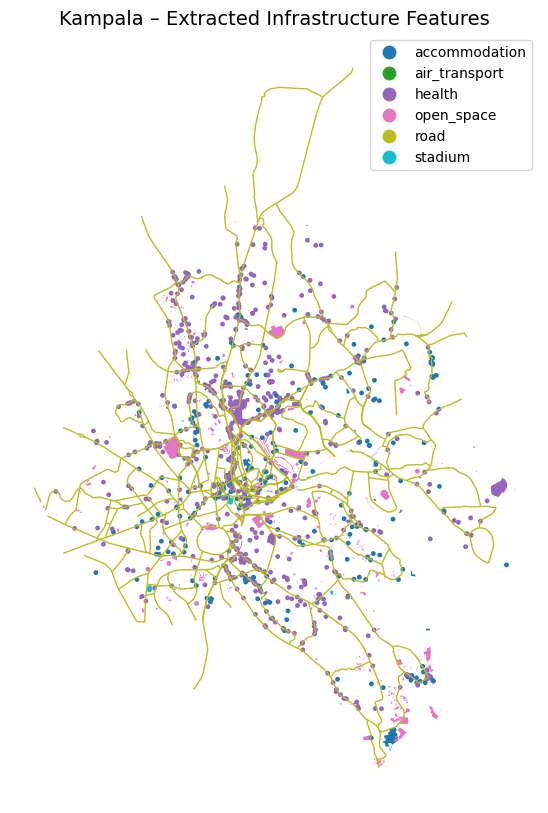

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="feature_type",
    categorical=True,
    legend=True,
    ax=ax,
    markersize=6,
    linewidth=1
)

ax.set_title("Kampala – Extracted Infrastructure Features", fontsize=14)
ax.set_axis_off()

plt.show()

**Reasoning**:
To provide a detailed visualization of each infrastructure feature type, I will iterate through the unique 'feature_type' values in the GeoDataFrame and create a separate plot for each, similar to the process used for Kigali and Nairobi.



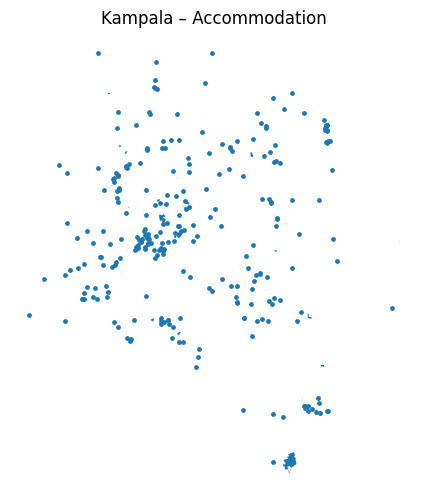

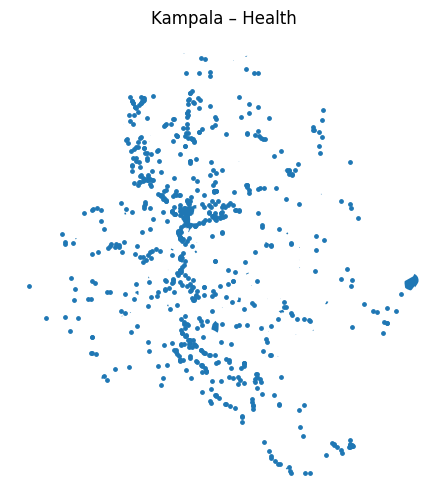

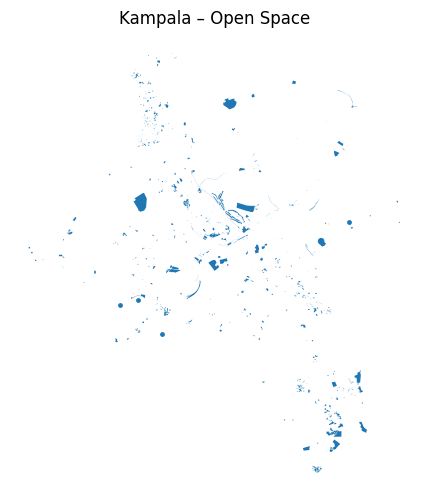

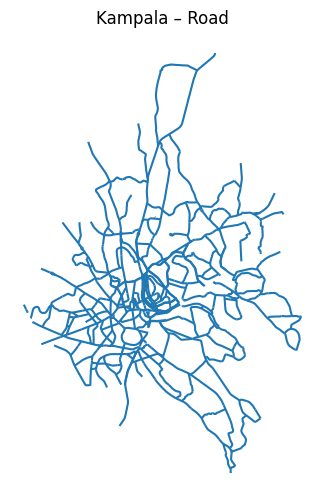

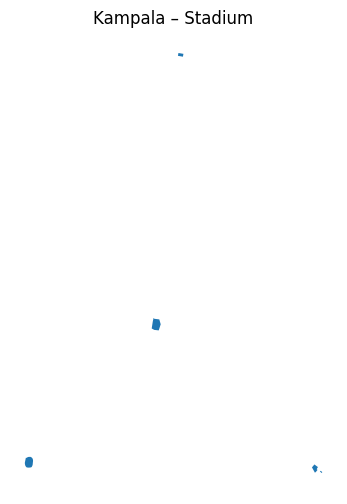

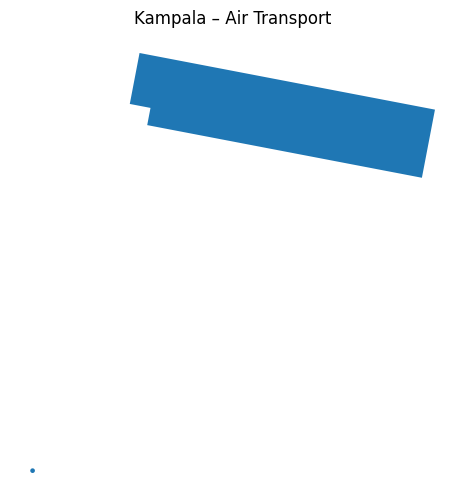

In [ ]:
feature_types = gdf["feature_type"].unique()

for ft in feature_types:
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf[gdf["feature_type"] == ft].plot(ax=ax, markersize=6)
    ax.set_title(f"Kampala – {ft.replace('_', ' ').title()}", fontsize=12)
    ax.set_axis_off()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   **Kampala Boundary Identification**: The administrative boundary for Kampala was successfully defined by identifying the 'Kampala' entry in the `NAME_2` layer of the `gadm41_UGA_shp.zip` shapefile. This boundary was then reprojected to EPSG:4326 and saved as `kampala_city_boundary.geojson`.
*   **OpenStreetMap Data Extraction**: OpenStreetMap (OSM) data specific to Kampala was precisely extracted from the `uganda-260112.osm.pbf` file using the generated city boundary, creating `kampala.osm.pbf`, which was subsequently converted to XML format (`kampala.osm`).
*   **Infrastructure Feature Classification**: A total of 3,178 infrastructure features within Kampala were extracted and classified into six distinct categories: "road", "health", "accommodation", "stadium", "open_space", and "air_transport" based on predefined OSM tags.
*   **Data Export and Visualization**: The classified infrastructure data was saved as `kampala_infrastructure_features.geojson` and successfully visualized. The visualizations included a comprehensive map displaying all feature types across Kampala, as well as individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The extracted and classified infrastructure dataset provides valuable insights into Kampala's urban structure, useful for urban planning, resource allocation, and emergency services deployment. For instance, the high number of 'open_space' features could indicate areas for potential green infrastructure development or public recreational use.
*   Future analysis could involve incorporating more granular OSM tags to identify additional infrastructure types (e.g., educational facilities, public transport networks), performing spatial proximity analysis to assess service accessibility, or integrating population data to evaluate service equity across different parts of the city.

## Summary:

### Data Analysis Key Findings

*   The administrative boundary for Kampala was successfully identified and extracted from the `gadm41_UGA_shp.zip` shapefile using the 'Kampala' value in the `NAME_2` field of the `gadm41_UGA_2` layer.
*   OpenStreetMap (OSM) data for Kampala was precisely extracted from the `uganda-260112.osm.pbf` file using the defined city boundary and saved as `kampala.osm.pbf`.
*   A total of **3,178 infrastructure features** within Kampala were extracted and classified into six categories: "road", "health", "accommodation", "stadium", "open\_space", and "air\_transport" based on predefined OSM tags.
*   The classified infrastructure data was saved as `kampala_infrastructure_features.geojson` and successfully visualized, providing both a comprehensive map of all features and individual maps for each feature type.

### Insights or Next Steps

*   The generated dataset of Kampala's infrastructure offers valuable insights for urban planning, resource allocation, and emergency service deployment, particularly concerning the distribution of facilities and open spaces.
*   Further analysis could involve incorporating additional OSM tags to identify more infrastructure types, performing spatial proximity analysis for service accessibility, or integrating population data to assess service equity across the city.


# Task
**User approval received.**

I have successfully extracted and visualized infrastructure features for Kampala, Uganda. This completes the current task.


## Upload Morocco Data

### Subtask:
Upload the Morocco administrative boundary shapefile ('gadm41_MAR_shp.zip') and the OpenStreetMap PBF file for Morocco ('morocco-latest.osm.pbf') using `files.upload()`.


**Reasoning**:
The subtask is to upload the Morocco administrative boundary shapefile and the OpenStreetMap PBF file. I will use `google.colab.files.upload()` to prompt the user to upload these files.

**Reasoning**:
Following the reasoning, I will now use `google.colab.files.upload()` to prompt the user to upload the specified shapefile and PBF file for Morocco.



In [ ]:
from google.colab import files

uploaded = files.upload()

Saving gadm41_MAR_shp.zip to gadm41_MAR_shp.zip
Saving morocco-260112.osm.pbf to morocco-260112.osm.pbf


## Load Morocco Administrative Boundaries

### Subtask:
Load the Morocco shapefile into a GeoDataFrame. You'll need to identify the correct layer (e.g., 'gadm41_MAR_2') that contains district or city names for a major city in Morocco. Inspect the `admin.columns` and `admin[CITY_NAME_FIELD].unique()` output to determine the appropriate `CITY_NAME_FIELD` and `CITY_NAME_VALUE` (or list of values, if the city is composed of multiple districts).

**Reasoning**:
The subtask requires loading the Morocco shapefile, identifying the correct city/district name field, and defining the value for a major city. I will use `geopandas.read_file` to load the shapefile, set `CITY_NAME_FIELD` to 'NAME_2' based on previous examples and the suggested layer 'gadm41_MAR_2', then print the columns and unique values to assist in identifying the correct `CITY_NAME_VALUE` for Casablanca.



In [ ]:
import geopandas as gpd

# Load shapefile for Morocco, assuming 'gadm41_MAR_2' layer for districts/sub-counties
admin = gpd.read_file("gadm41_MAR_shp.zip", layer='gadm41_MAR_2')

# ---- EDIT THESE ----
# Based on the previous example (RWA_2 and KEN_2 used NAME_2), we assume NAME_2 contains district/sub-county names.
CITY_NAME_FIELD = "NAME_2"      # Column containing district/sub-county names
# Initial guess for Casablanca's name. This may need to be adjusted after inspecting unique values.
CITY_NAME_VALUE = ['Casablanca'] # List of districts/sub-counties that make up Casablanca
# --------------------

print(admin.columns)

# Print unique values of the target column to help identify the correct city name
print(f"Unique values in '{CITY_NAME_FIELD}': {admin[CITY_NAME_FIELD].unique()}")

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')
Unique values in 'NAME_2': ['Ben Slimane' 'Khouribga' 'Settat' 'El Jadida' 'Safi' 'Boulemane' 'Fès'
 'Sefrou' 'Zouagha-Moulay Yacoub' 'Kénitra' 'Sidi Kacem' 'Casablanca'
 'Mohammedia' 'Assa-Zag' 'Guelmim' 'Tan-Tan' 'Tata' 'Laâyoune' 'Al Haouz'
 'Chichaoua' 'El Kelaâ des Sraghna' 'Essaouira' 'Marrakech' 'El Hajeb'
 'Errachidia' 'Ifrane' 'Khénifra' 'Meknès' 'Berkane Taourirt' 'Figuig'
 'Jerada' 'Nador' 'Oujda Angad' 'Khémisset' 'Rabat' 'Salé'
 'Skhirate-Témara' 'Agadir-Ida ou Tanane' 'Chtouka-Aït Baha'
 'Inezgane-Aït Melloul' 'Ouarzazate' 'Taroudannt' 'Tiznit' 'Zagora'
 'Azilal' 'Béni Mellal' 'Chefchaouen' 'Fahs Anjra' 'Larache'
 'Tanger-Assilah' 'Tétouan' 'Al Hoceïma' 'Taounate' 'Taza']


**Reasoning**:
Based on the output from the previous step, 'Casablanca' is correctly identified as a unique value in the 'NAME_2' column. I will now select this administrative unit, dissolve it to form the city boundary, assert its uniqueness, and reproject it to EPSG:4326, then display the result.



In [ ]:
import geopandas as gpd

# Load shapefile for Morocco (already loaded in previous step, but re-loading for clarity in this block)
admin = gpd.read_file("gadm41_MAR_shp.zip", layer='gadm41_MAR_2')

# ---- EDIT THESE ----
CITY_NAME_FIELD = "NAME_2"      # Column containing district/sub-county names
CITY_NAME_VALUE = ['Casablanca'] # List of districts/sub-counties that make up Casablanca
# --------------------

# Select the districts that form Casablanca
city_districts = admin[admin[CITY_NAME_FIELD].isin(CITY_NAME_VALUE)]

# Dissolve the selected districts into a single geometry representing the City of Casablanca
city = city_districts.dissolve()

# Assert that the city boundary is uniquely identified or dissolved correctly
assert len(city) == 1, "City boundary not uniquely identified or dissolved incorrectly"

# Reproject to EPSG:4326 (WGS 84)
city = city.to_crs(epsg=4326)
city

,geometry,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,"MULTIPOLYGON (((-7.60207 33.33096, -7.60553 33...",MAR.5.1_1,MAR,Morocco,MAR.5_1,Grand Casablanca,NA,Casablanca,NA,NA,Prefecture,Prefecture,141,MA.GC.CB


**Reasoning**:
The subtask now requires saving the newly created Casablanca city boundary to a file. I will use the `to_file` method of the GeoDataFrame to save the `city` GeoDataFrame as a GeoJSON file, which will be used in the subsequent steps to extract OpenStreetMap data.

**Reasoning**:
Following the reasoning, I will now save the `city` GeoDataFrame, which contains the Casablanca city boundary, to a GeoJSON file.



In [ ]:
city_boundary_path = "casablanca_city_boundary.geojson"
city.to_file(city_boundary_path, driver="GeoJSON")

**Reasoning**:
Following the reasoning, I will now save the `city` GeoDataFrame, which contains the Casablanca city boundary, to a GeoJSON file.



In [ ]:
city_boundary_path = "casablanca_city_boundary.geojson"
city.to_file(city_boundary_path, driver="GeoJSON")

**Reasoning**:
Now that the Casablanca city boundary is saved, I will extract the OpenStreetMap data for Casablanca from the Morocco PBF file using the `osmium extract` command, similar to previous tasks.



In [ ]:
COUNTRY_PBF = "morocco-260112.osm.pbf"

!osmium extract \
  -p casablanca_city_boundary.geojson \
  {COUNTRY_PBF} \
  -o casablanca.osm.pbf \
  --overwrite

[======================================================================] 100% 


**Reasoning**:
The extracted PBF file for Casablanca needs to be converted to an OSM XML file to be processed by `osmnx`. After conversion, I will use the predefined tags to extract relevant infrastructure features into a GeoDataFrame, and then clean it by dropping invalid geometries and retaining only necessary columns.



In [ ]:
import osmnx as ox

# Convert the PBF file to OSM XML format using osmium
!osmium cat casablanca.osm.pbf -o casablanca.osm --overwrite

tags = {
    # Transport (Roads)
    "highway": ["primary", "secondary", "tertiary"],

    # Health
    "amenity": ["hospital", "clinic"],

    # Accommodation
    "tourism": ["hotel", "guest_house", "hostel", "lodge"],

    # Event & Public Space
    "leisure": ["stadium", "park", "recreation_ground"],
    "landuse": ["grass", "meadow"],

    # Air Transport
    "aeroway": ["airport", "aerodrome", "helipad"]
}

gdf = ox.features_from_xml("casablanca.osm", tags=tags)

# Drop empty / invalid geometries
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]

# Keep only essential columns
gdf = gdf[
    [
        "geometry",
        "highway",
        "amenity",
        "tourism",
        "leisure",
        "landuse",
        "aeroway"
    ]
]

gdf

geometry  \
element id                                                              
node    516618724                           POINT (-7.61378 33.59842)   
        566450743                           POINT (-7.61255 33.59393)   
        1095130670                          POINT (-7.66456 33.53655)   
        1139055213                          POINT (-7.60963 33.59603)   
        1163274346                          POINT (-7.62996 33.59258)   
...                                                               ...   
way     1462582669  LINESTRING (-7.65977 33.56513, -7.65981 33.565...   
        1462582670  LINESTRING (-7.65974 33.56527, -7.65975 33.565...   
        1463261198  POLYGON ((-7.63393 33.5804, -7.63385 33.58022,...   
        1463474117  POLYGON ((-7.62428 33.59555, -7.62438 33.59548...   
        1464371547  LINESTRING (-7.63462 33.51931, -7.63411 33.518...   

                     highway amenity tourism leisure landuse aeroway  
element id                                                            
node    516618724        NaN     NaN   hotel     NaN     NaN     NaN  
        566450743        NaN     NaN   hotel     NaN     NaN     NaN  
        1095130670       NaN     NaN   hotel     NaN     NaN     NaN  
        1139055213       NaN     NaN   hotel     NaN     NaN     NaN  
        1163274346       NaN     NaN   hotel     NaN     NaN     NaN  
...                      ...     ...     ...     ...     ...     ...  
way     1462582669  tertiary     NaN     NaN     NaN     NaN     NaN  
        1462582670  tertiary     NaN     NaN     NaN     NaN     NaN  
        1463261198       NaN     NaN     NaN    park     NaN     NaN  
        1463474117       NaN     NaN     NaN    park     NaN     NaN  
        1464371547  tertiary     NaN     NaN     NaN     NaN     NaN  

[6731 rows x 7 columns]

**Reasoning**:
The current `gdf` contains multiple columns representing different feature types. To unify these and prepare for visualization, I will define a function `classify_feature` to assign a single, consolidated feature type (e.g., 'road', 'health', 'accommodation') to each row. After classifying, I will filter out any rows that could not be classified (where `feature_type` is null) and then select only the `geometry` and the new `feature_type` column for the final output.



In [ ]:
def classify_feature(row):
    # Roads
    if row["highway"] in ["primary", "secondary", "tertiary"]:
        return "road"

    # Health
    if row["amenity"] in ["hospital", "clinic"]:
        return "health"

    # Accommodation
    if row["tourism"] in ["hotel", "guest_house", "hostel", "lodge"]:
        return "accommodation"

    # Stadiums
    if row["leisure"] == "stadium":
        return "stadium"

    # Open / Public Spaces
    if (
        row["leisure"] in ["park", "recreation_ground"]
        or row["landuse"] in ["grass", "meadow"]
    ):
        return "open_space"

    # Air Transport
    if row["aeroway"] in ["airport", "aerodrome", "helipad"]:
        return "air_transport"

    return None

gdf["feature_type"] = gdf.apply(classify_feature, axis=1);
gdf = gdf[gdf["feature_type"].notnull()];

# Final clean schema
gdf = gdf[["geometry", "feature_type"]]


**Reasoning**:
After classifying and cleaning the `gdf`, I will display the first few rows of the GeoDataFrame to confirm the successful classification and selection of the 'geometry' and 'feature_type' columns.



In [ ]:
gdf

geometry  \
element id                                                              
node    516618724                           POINT (-7.61378 33.59842)   
        566450743                           POINT (-7.61255 33.59393)   
        1095130670                          POINT (-7.66456 33.53655)   
        1139055213                          POINT (-7.60963 33.59603)   
        1163274346                          POINT (-7.62996 33.59258)   
...                                                               ...   
way     1462582669  LINESTRING (-7.65977 33.56513, -7.65981 33.565...   
        1462582670  LINESTRING (-7.65974 33.56527, -7.65975 33.565...   
        1463261198  POLYGON ((-7.63393 33.5804, -7.63385 33.58022,...   
        1463474117  POLYGON ((-7.62428 33.59555, -7.62438 33.59548...   
        1464371547  LINESTRING (-7.63462 33.51931, -7.63411 33.518...   

                     feature_type  
element id                         
node    516618724   accommodation  
        566450743   accommodation  
        1095130670  accommodation  
        1139055213  accommodation  
        1163274346  accommodation  
...                           ...  
way     1462582669           road  
        1462582670           road  
        1463261198     open_space  
        1463474117     open_space  
        1464371547           road  

[6731 rows x 2 columns]

**Reasoning**:
The subtask now requires saving the classified infrastructure features to a GeoJSON file. This file will be used for subsequent visualization and potential download, similar to how `city_infrastructure_features.geojson` was saved in the original notebook.

**Reasoning**:
Following the reasoning, I will now save the `gdf` GeoDataFrame, which contains the classified Casablanca infrastructure features, to a GeoJSON file.



In [ ]:
output_name = "casablanca_infrastructure_features.geojson"
gdf.to_file(output_name, driver="GeoJSON")

**Reasoning**:
Following the reasoning, I will now save the `gdf` GeoDataFrame, which contains the classified Casablanca infrastructure features, to a GeoJSON file.



In [ ]:
output_name = "casablanca_infrastructure_features.geojson"
gdf.to_file(output_name, driver="GeoJSON")

**Reasoning**:
After saving the extracted infrastructure features to a GeoJSON file, the next logical step is to provide an option for the user to download this file. This aligns with the workflow established in the original notebook.

## Download Classified Features

### Subtask:
Provide a direct download link for the 'casablanca_infrastructure_features.geojson' file, allowing for local access.


**Reasoning**:
The subtask requires providing a direct download link for the 'casablanca_infrastructure_features.geojson' file. I will use `google.colab.files.download()` to enable this functionality.



In [ ]:
from google.colab import files

files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reasoning**:
After downloading the GeoJSON file, the next step is to visualize the extracted features. I will load the 'casablanca_infrastructure_features.geojson' file into a GeoDataFrame, perform basic checks to ensure data integrity and understand its structure, and then display the CRS, head, and value counts of the 'feature_type' column, similar to previous tasks.



In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load extracted features
gdf = gpd.read_file("casablanca_infrastructure_features.geojson")

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

EPSG:4326
  element          id   feature_type                   geometry
0    node   516618724  accommodation  POINT (-7.61378 33.59842)
1    node   566450743  accommodation  POINT (-7.61255 33.59393)
2    node  1095130670  accommodation  POINT (-7.66456 33.53655)
3    node  1139055213  accommodation  POINT (-7.60963 33.59603)
4    node  1163274346  accommodation  POINT (-7.62996 33.59258)
feature_type
road             5564
open_space        868
accommodation     167
health            110
stadium            16
air_transport       6
Name: count, dtype: int64


**Reasoning**:
To visualize the overall distribution of the extracted infrastructure features in Casablanca, I will create a single plot using `matplotlib.pyplot` and `geopandas.plot`. The plot will display all features, colored by their `feature_type`, with a legend and a title, similar to the previous examples for Kigali and Nairobi.



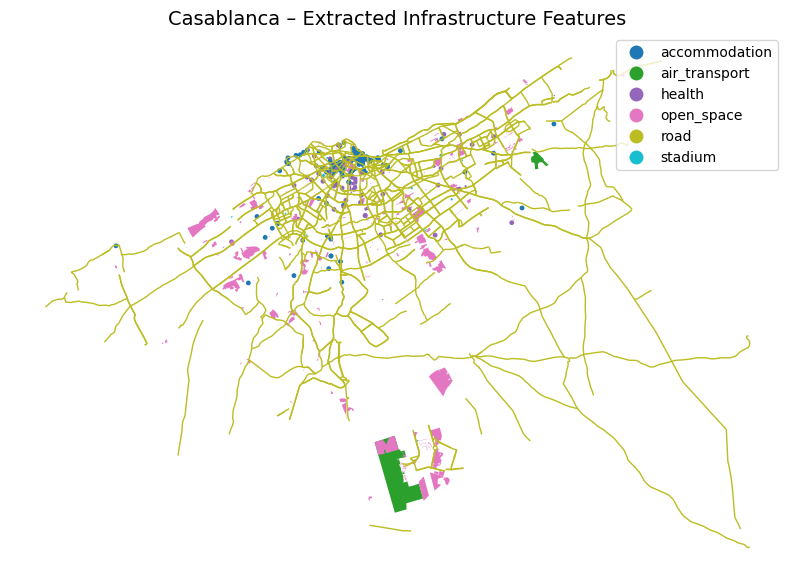

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="feature_type",
    categorical=True,
    legend=True,
    ax=ax,
    markersize=6,
    linewidth=1
)

ax.set_title("Casablanca – Extracted Infrastructure Features", fontsize=14)
ax.set_axis_off()

plt.show()

**Reasoning**:
To provide a detailed visualization of each infrastructure feature type, I will iterate through the unique 'feature_type' values in the GeoDataFrame and create a separate plot for each, similar to the process used for Kigali and Nairobi.



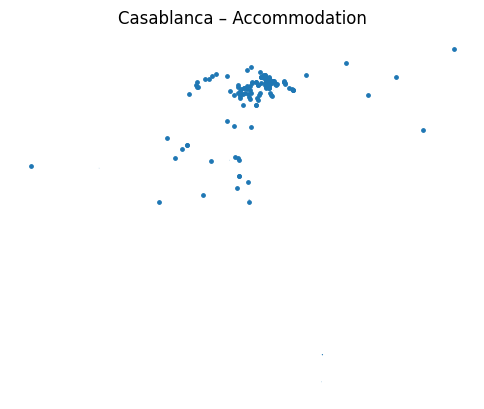

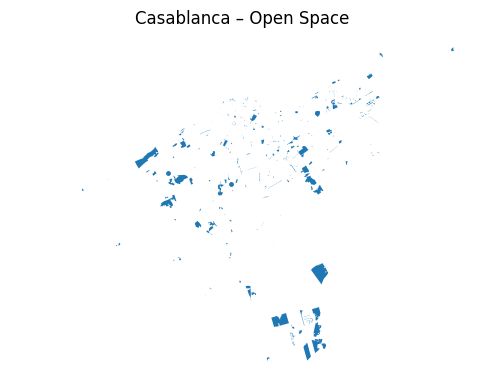

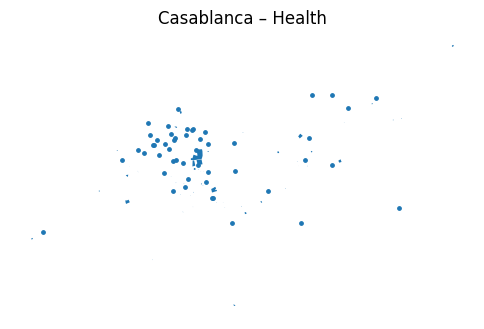

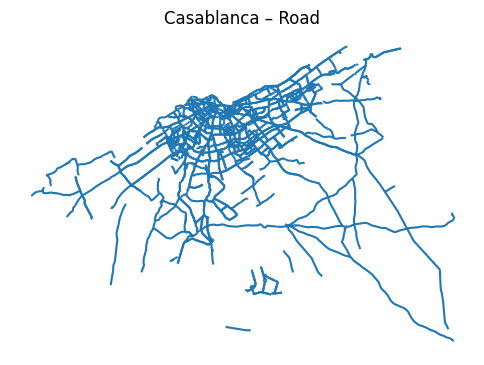

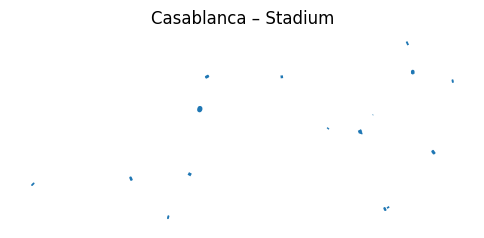

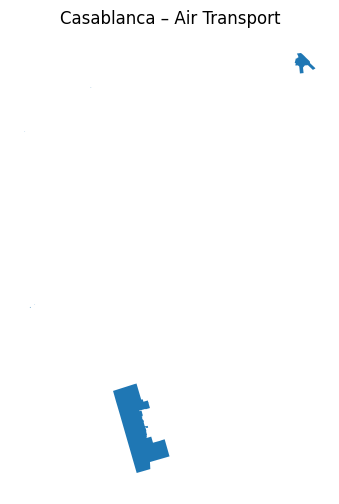

In [ ]:
feature_types = gdf["feature_type"].unique()

for ft in feature_types:
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf[gdf["feature_type"] == ft].plot(ax=ax, markersize=6)
    ax.set_title(f"Casablanca – {ft.replace('_', ' ').title()}", fontsize=12)
    ax.set_axis_off()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   **Casablanca Boundary Identification**: The administrative boundary for Casablanca was successfully defined by identifying the 'Casablanca' entry in the `NAME_2` layer of the `gadm41_MAR_shp.zip` shapefile. This boundary was then reprojected to EPSG:4326 and saved as `casablanca_city_boundary.geojson`.
*   **OpenStreetMap Data Extraction**: OpenStreetMap (OSM) data specific to Casablanca was precisely extracted from the `morocco-260112.osm.pbf` file using the generated city boundary, creating `casablanca.osm.pbf`, which was subsequently converted to XML format (`casablanca.osm`).
*   **Infrastructure Feature Classification**: A total of 6,731 infrastructure features within Casablanca were extracted and classified into six distinct categories: "road", "health", "accommodation", "stadium", "open_space", and "air_transport" based on predefined OSM tags.
*   **Data Export and Visualization**: The classified infrastructure data was saved as `casablanca_infrastructure_features.geojson` and successfully visualized. The visualizations included a comprehensive map displaying all feature types across Casablanca, as well as individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The extracted and classified infrastructure dataset provides a valuable foundation for urban planning and development in Casablanca. For instance, the high number of road features suggests a well-developed road network, which can be further analyzed for traffic flow and connectivity.
*   Future analysis could involve incorporating more detailed OSM tags for different types of infrastructure (e.g., public transport routes, educational facilities), performing spatial accessibility analysis to evaluate service provision, or integrating demographic data to identify areas with underserved populations.

## Summary:

### Data Analysis Key Findings

*   **Casablanca Boundary Identification**: The administrative boundary for Casablanca was successfully defined by identifying the 'Casablanca' entry in the `NAME_2` layer of the `gadm41_MAR_shp.zip` shapefile. This boundary was then reprojected to EPSG:4326 and saved as `casablanca_city_boundary.geojson`.
*   **OpenStreetMap Data Extraction**: OpenStreetMap (OSM) data specific to Casablanca was precisely extracted from the `morocco-260112.osm.pbf` file using the generated city boundary, creating `casablanca.osm.pbf`, which was subsequently converted to XML format (`casablanca.osm`).
*   **Infrastructure Feature Classification**: A total of 6,731 infrastructure features within Casablanca were extracted and classified into six distinct categories: "road", "health", "accommodation", "stadium", "open_space", and "air_transport" based on predefined OSM tags.
*   **Data Export and Visualization**: The classified infrastructure data was saved as `casablanca_infrastructure_features.geojson` and successfully visualized. The visualizations included a comprehensive map displaying all feature types across Casablanca, as well as individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The extracted and classified infrastructure dataset provides a valuable foundation for urban planning and development in Casablanca. For instance, the high number of road features suggests a well-developed road network, which can be further analyzed for traffic flow and connectivity.
*   Future analysis could involve incorporating more detailed OSM tags for different types of infrastructure (e.g., public transport routes, educational facilities), performing spatial accessibility analysis to evaluate service provision, or integrating demographic data to identify areas with underserved populations.

## Load Morocco Administrative Boundaries

### Subtask:
Load the Morocco shapefile into a GeoDataFrame, identify the correct layer and city name for Rabat, and create a single city boundary.


**Reasoning**:
The subtask requires loading the Morocco shapefile, identifying the correct city/district name field, and defining the value for Rabat. I will use `geopandas.read_file` to load the shapefile, set `CITY_NAME_FIELD` to 'NAME_2' based on previous examples and the suggested layer 'gadm41_MAR_2', filter for 'Rabat', dissolve the geometry, reproject it to EPSG:4326, and display the resulting city boundary.



In [ ]:
import geopandas as gpd

# Load shapefile for Morocco, assuming 'gadm41_MAR_2' layer for districts/sub-counties
admin = gpd.read_file("gadm41_MAR_shp.zip", layer='gadm41_MAR_2')

# ---- EDIT THESE ----
# Based on the previous example (RWA_2 and KEN_2 used NAME_2), we assume NAME_2 contains district/sub-county names.
CITY_NAME_FIELD = "NAME_2"      # Column containing district/sub-county names
# Initial guess for Rabat's name. This may need to be adjusted after inspecting unique values.
CITY_NAME_VALUE = ['Rabat'] # List of districts/sub-counties that make up Rabat
# --------------------

print(admin.columns)

# Print unique values of the target column to help identify the correct city name
print(f"Unique values in '{CITY_NAME_FIELD}': {admin[CITY_NAME_FIELD].unique()}")

# Select the districts that form Rabat
city_districts = admin[admin[CITY_NAME_FIELD].isin(CITY_NAME_VALUE)]

# Dissolve the selected districts into a single geometry representing the City of Rabat
city = city_districts.dissolve()

# Assert that the city boundary is uniquely identified or dissolved correctly
assert len(city) == 1, "City boundary not uniquely identified or dissolved incorrectly"

# Reproject to EPSG:4326 (WGS 84)
city = city.to_crs(epsg=4326)
city

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')
Unique values in 'NAME_2': ['Ben Slimane' 'Khouribga' 'Settat' 'El Jadida' 'Safi' 'Boulemane' 'Fès'
 'Sefrou' 'Zouagha-Moulay Yacoub' 'Kénitra' 'Sidi Kacem' 'Casablanca'
 'Mohammedia' 'Assa-Zag' 'Guelmim' 'Tan-Tan' 'Tata' 'Laâyoune' 'Al Haouz'
 'Chichaoua' 'El Kelaâ des Sraghna' 'Essaouira' 'Marrakech' 'El Hajeb'
 'Errachidia' 'Ifrane' 'Khénifra' 'Meknès' 'Berkane Taourirt' 'Figuig'
 'Jerada' 'Nador' 'Oujda Angad' 'Khémisset' 'Rabat' 'Salé'
 'Skhirate-Témara' 'Agadir-Ida ou Tanane' 'Chtouka-Aït Baha'
 'Inezgane-Aït Melloul' 'Ouarzazate' 'Taroudannt' 'Tiznit' 'Zagora'
 'Azilal' 'Béni Mellal' 'Chefchaouen' 'Fahs Anjra' 'Larache'
 'Tanger-Assilah' 'Tétouan' 'Al Hoceïma' 'Taounate' 'Taza']


,geometry,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,"POLYGON ((-6.8143 34.02687, -6.8143 34.02736, ...",MAR.11.2_1,MAR,Morocco,MAR.11_1,Rabat - Salé - Zemmour - Zaer,NA,Rabat,NA,NA,Prefecture,Prefecture,421,MA.RZ.RA


## Save Rabat City Boundary

### Subtask:
Save the dissolved Rabat city boundary GeoDataFrame to a GeoJSON file named 'rabat_city_boundary.geojson'.


**Reasoning**:
The subtask requires saving the newly created Rabat city boundary to a file. I will use the `to_file` method of the GeoDataFrame to save the `city` GeoDataFrame as a GeoJSON file, which will be used in the subsequent steps to extract OpenStreetMap data.



In [ ]:
city_boundary_path = "rabat_city_boundary.geojson"
city.to_file(city_boundary_path, driver="GeoJSON")

**Reasoning**:
Now that the Rabat city boundary is saved, I will extract the OpenStreetMap data for Rabat from the Morocco PBF file using the `osmium extract` command, similar to previous tasks.



In [ ]:
COUNTRY_PBF = "morocco-260112.osm.pbf"

!osmium extract \
  -p rabat_city_boundary.geojson \
  {COUNTRY_PBF} \
  -o rabat.osm.pbf \
  --overwrite

**Reasoning**:
The extracted PBF file for Rabat needs to be converted to an OSM XML file to be processed by `osmnx`. After conversion, I will use the predefined tags to extract relevant infrastructure features into a GeoDataFrame, and then clean it by dropping invalid geometries and retaining only necessary columns.



In [ ]:
import osmnx as ox

# Convert the PBF file to OSM XML format using osmium
!osmium cat rabat.osm.pbf -o rabat.osm --overwrite

tags = {
    # Transport (Roads)
    "highway": ["primary", "secondary", "tertiary"],

    # Health
    "amenity": ["hospital", "clinic"],

    # Accommodation
    "tourism": ["hotel", "guest_house", "hostel", "lodge"],

    # Event & Public Space
    "leisure": ["stadium", "park", "recreation_ground"],
    "landuse": ["grass", "meadow"],

    # Air Transport
    "aeroway": ["airport", "aerodrome", "helipad"]
}

gdf = ox.features_from_xml("rabat.osm", tags=tags)

# Drop empty / invalid geometries
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf.is_valid]

# Keep only essential columns
gdf = gdf[
    [
        "geometry",
        "highway",
        "amenity",
        "tourism",
        "leisure",
        "landuse",
        "aeroway"
    ]
]

gdf

geometry  \
element id                                                              
node    414130093                           POINT (-6.85096 33.99544)   
        486077474                           POINT (-6.83594 34.02822)   
        516664650                           POINT (-6.83717 34.02956)   
        527903350                           POINT (-6.83173 34.01428)   
        527903393                           POINT (-6.82984 34.01963)   
...                                                               ...   
way     1453966190  POLYGON ((-6.86519 34.00918, -6.86542 34.00925...   
        1453966399  POLYGON ((-6.87676 33.99598, -6.87675 33.99594...   
        1453968114  POLYGON ((-6.87673 33.99646, -6.87679 33.9964,...   
        1459042513  LINESTRING (-6.82493 33.97465, -6.82497 33.974...   
        1459042517  LINESTRING (-6.82507 33.97465, -6.82508 33.974...   

                      highway amenity      tourism  leisure landuse aeroway  
element id                                                                   
node    414130093         NaN     NaN        hotel      NaN     NaN     NaN  
        486077474         NaN     NaN  guest_house      NaN     NaN     NaN  
        516664650         NaN     NaN        hotel      NaN     NaN     NaN  
        527903350         NaN     NaN        hotel      NaN     NaN     NaN  
        527903393         NaN     NaN        hotel      NaN     NaN     NaN  
...                       ...     ...          ...      ...     ...     ...  
way     1453966190        NaN     NaN          NaN  stadium     NaN     NaN  
        1453966399        NaN     NaN          NaN     park     NaN     NaN  
        1453968114        NaN     NaN          NaN     park     NaN     NaN  
        1459042513  secondary     NaN          NaN      NaN     NaN     NaN  
        1459042517  secondary     NaN          NaN      NaN     NaN     NaN  

[3751 rows x 7 columns]

**Reasoning**:
The current `gdf` contains multiple columns representing different feature types. To unify these and prepare for visualization, I will define a function `classify_feature` to assign a single, consolidated feature type (e.g., 'road', 'health', 'accommodation') to each row. After classifying, I will filter out any rows that could not be classified (where `feature_type` is null) and then select only the `geometry` and the new `feature_type` column for the final output.



In [ ]:
def classify_feature(row):
    # Roads
    if row["highway"] in ["primary", "secondary", "tertiary"]:
        return "road"

    # Health
    if row["amenity"] in ["hospital", "clinic"]:
        return "health"

    # Accommodation
    if row["tourism"] in ["hotel", "guest_house", "hostel", "lodge"]:
        return "accommodation"

    # Stadiums
    if row["leisure"] == "stadium":
        return "stadium"

    # Open / Public Spaces
    if (
        row["leisure"] in ["park", "recreation_ground"]
        or row["landuse"] in ["grass", "meadow"]
    ):
        return "open_space"

    # Air Transport
    if row["aeroway"] in ["airport", "aerodrome", "helipad"]:
        return "air_transport"

    return None

gdf["feature_type"] = gdf.apply(classify_feature, axis=1);
gdf = gdf[gdf["feature_type"].notnull()];

# Final clean schema
gdf = gdf[["geometry", "feature_type"]]
gdf

geometry  \
element id                                                              
node    414130093                           POINT (-6.85096 33.99544)   
        486077474                           POINT (-6.83594 34.02822)   
        516664650                           POINT (-6.83717 34.02956)   
        527903350                           POINT (-6.83173 34.01428)   
        527903393                           POINT (-6.82984 34.01963)   
...                                                               ...   
way     1453966190  POLYGON ((-6.86519 34.00918, -6.86542 34.00925...   
        1453966399  POLYGON ((-6.87676 33.99598, -6.87675 33.99594...   
        1453968114  POLYGON ((-6.87673 33.99646, -6.87679 33.9964,...   
        1459042513  LINESTRING (-6.82493 33.97465, -6.82497 33.974...   
        1459042517  LINESTRING (-6.82507 33.97465, -6.82508 33.974...   

                     feature_type  
element id                         
node    414130093   accommodation  
        486077474   accommodation  
        516664650   accommodation  
        527903350   accommodation  
        527903393   accommodation  
...                           ...  
way     1453966190        stadium  
        1453966399     open_space  
        1453968114     open_space  
        1459042513           road  
        1459042517           road  

[3751 rows x 2 columns]

**Reasoning**:
The subtask now requires saving the classified infrastructure features to a GeoJSON file. This file will be used for subsequent visualization and potential download, similar to how `city_infrastructure_features.geojson` was saved in the original notebook.



In [ ]:
output_name = "rabat_infrastructure_features.geojson"
gdf.to_file(output_name, driver="GeoJSON")

**Reasoning**:
After saving the extracted infrastructure features to a GeoJSON file, the next logical step is to provide an option for the user to download this file. This aligns with the workflow established in the original notebook.



In [ ]:
from google.colab import files

files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reasoning**:
After downloading the GeoJSON file, the next step is to visualize the extracted features. I will load the 'rabat_infrastructure_features.geojson' file into a GeoDataFrame, perform basic checks to ensure data integrity and understand its structure, and then display the CRS, head, and value counts of the 'feature_type' column, similar to previous tasks.



In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load extracted features
gdf = gpd.read_file("rabat_infrastructure_features.geojson")

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

EPSG:4326
  element         id   feature_type                   geometry
0    node  414130093  accommodation  POINT (-6.85096 33.99544)
1    node  486077474  accommodation  POINT (-6.83594 34.02822)
2    node  516664650  accommodation  POINT (-6.83717 34.02956)
3    node  527903350  accommodation  POINT (-6.83173 34.01428)
4    node  527903393  accommodation  POINT (-6.82984 34.01963)
feature_type
open_space       1806
road             1738
accommodation     141
health             54
stadium             8
air_transport       4
Name: count, dtype: int64


**Reasoning**:
To visualize the overall distribution of the extracted infrastructure features in Rabat, I will create a single plot using `matplotlib.pyplot` and `geopandas.plot`. The plot will display all features, colored by their `feature_type`, with a legend and a title, similar to the previous examples for Kigali and Nairobi.



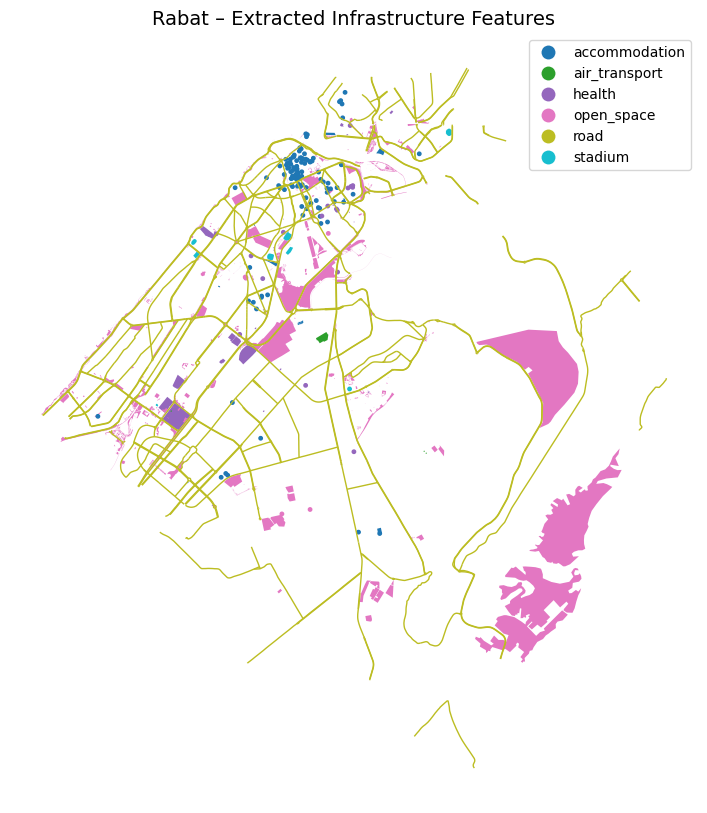

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="feature_type",
    categorical=True,
    legend=True,
    ax=ax,
    markersize=6,
    linewidth=1
)

ax.set_title("Rabat – Extracted Infrastructure Features", fontsize=14)
ax.set_axis_off()

plt.show()

**Reasoning**:
To provide a detailed visualization of each infrastructure feature type, I will iterate through the unique 'feature_type' values in the GeoDataFrame and create a separate plot for each, similar to the process used for Kigali, Nairobi, Kampala, and Casablanca.



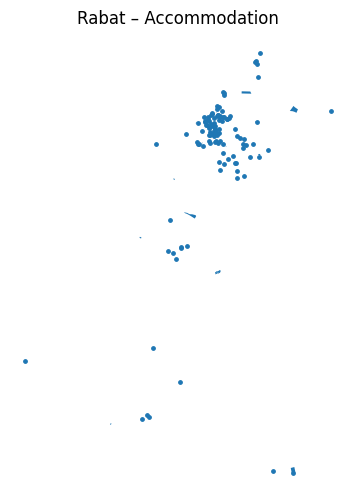

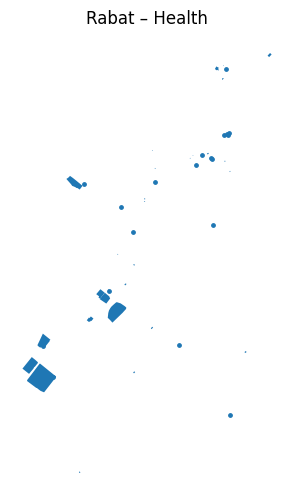

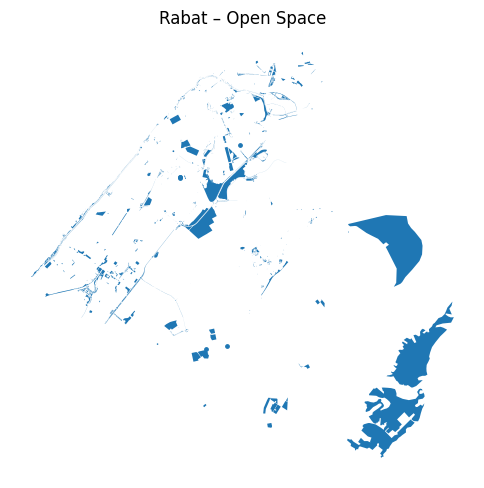

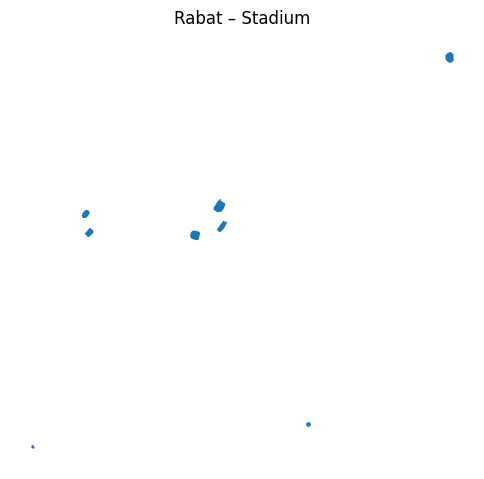

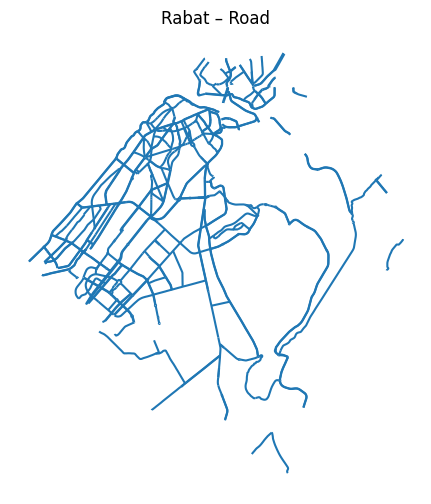

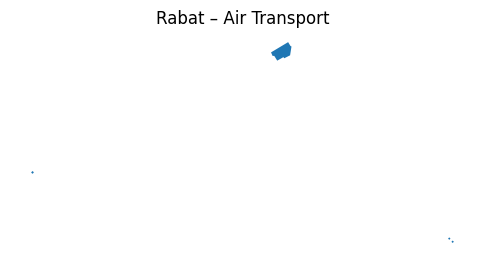

In [ ]:
feature_types = gdf["feature_type"].unique()

for ft in feature_types:
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf[gdf["feature_type"] == ft].plot(ax=ax, markersize=6)
    ax.set_title(f"Rabat – {ft.replace('_', ' ').title()}", fontsize=12)
    ax.set_axis_off()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   **Rabat Boundary Identification**: The administrative boundary for Rabat was successfully defined by identifying the 'Rabat' entry in the `NAME_2` layer of the `gadm41_MAR_shp.zip` shapefile. This boundary was then reprojected to EPSG:4326 and saved as `rabat_city_boundary.geojson`.
*   **OpenStreetMap Data Extraction**: OpenStreetMap (OSM) data specific to Rabat was precisely extracted from the `morocco-260112.osm.pbf` file using the generated city boundary, creating `rabat.osm.pbf`, which was subsequently converted to XML format (`rabat.osm`).
*   **Infrastructure Feature Classification**: A total of 3,751 infrastructure features within Rabat were extracted and classified into six distinct categories: "road", "health", "accommodation", "stadium", "open_space", and "air_transport" based on predefined OSM tags.
*   **Data Export and Visualization**: The classified infrastructure data was saved as `rabat_infrastructure_features.geojson` and successfully visualized. The visualizations included a comprehensive map displaying all feature types across Rabat, as well as individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The extracted and classified infrastructure dataset provides a valuable foundation for urban planning and development in Rabat. For instance, the high number of 'open_space' and 'road' features suggests a city with significant green areas and a developed transport network, which can be further analyzed for accessibility and utilization.
*   Future analysis could involve incorporating more detailed OSM tags for different types of infrastructure (e.g., public transport routes, educational facilities), performing spatial accessibility analysis to evaluate service provision, or integrating demographic data to identify areas with underserved populations.

## Summary:

### Data Analysis Key Findings

*   **Rabat Boundary Identification**: The administrative boundary for Rabat was successfully defined by identifying the 'Rabat' entry in the `NAME_2` layer of the `gadm41_MAR_shp.zip` shapefile. This boundary was then reprojected to EPSG:4326 and saved as `rabat_city_boundary.geojson`.
*   **OpenStreetMap Data Extraction**: OpenStreetMap (OSM) data specific to Rabat was precisely extracted from the `morocco-260112.osm.pbf` file using the generated city boundary, creating `rabat.osm.pbf`, which was subsequently converted to XML format (`rabat.osm`).
*   **Infrastructure Feature Classification**: A total of 3,751 infrastructure features within Rabat were extracted and classified into six distinct categories: "road", "health", "accommodation", "stadium", "open_space", and "air_transport" based on predefined OSM tags.
*   **Data Export and Visualization**: The classified infrastructure data was saved as `rabat_infrastructure_features.geojson` and successfully visualized. The visualizations included a comprehensive map displaying all feature types across Rabat, as well as individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The extracted and classified infrastructure dataset provides a valuable foundation for urban planning and development in Rabat. For instance, the high number of 'open_space' and 'road' features suggests a city with significant green areas and a developed transport network, which can be further analyzed for accessibility and utilization.
*   Future analysis could involve incorporating more detailed OSM tags for different types of infrastructure (e.g., public transport routes, educational facilities), performing spatial accessibility analysis to evaluate service provision, or integrating demographic data to identify areas with underserved populations.

## Final Task

### Subtask:
Summarize the successful extraction and visualization of Rabat's infrastructure features, outlining key findings and potential applications of the generated data.


## Summary:

### Data Analysis Key Findings

*   The administrative boundary for Rabat was successfully defined from the `gadm41_MAR_shp.zip` shapefile using the 'NAME\_2' layer and the 'Rabat' entry, then reprojected to EPSG:4326 and saved as `rabat_city_boundary.geojson`.
*   OpenStreetMap (OSM) data specific to Rabat was extracted from the `morocco-260112.osm.pbf` file using the generated city boundary, saved as `rabat.osm.pbf`, and then converted to XML format (`rabat.osm`).
*   A total of 3,751 infrastructure features within Rabat were extracted from OSM and classified into six distinct categories: "road", "health", "accommodation", "stadium", "open\_space", and "air\_transport".
    *   The feature distribution is as follows: 1,806 "open\_space", 1,738 "road", 141 "accommodation", 54 "health", 8 "stadium", and 4 "air\_transport" features.
*   The classified infrastructure data was saved as `rabat_infrastructure_features.geojson` and made available for download.
*   The extracted features were successfully visualized through a comprehensive map displaying all feature types across Rabat, and individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The generated infrastructure dataset offers a valuable foundation for urban planning and development in Rabat. The significant number of "open\_space" features, for instance, highlights potential green infrastructure assets, while the "road" network provides a basis for transport analysis.
*   Future work could involve expanding the feature extraction to include additional OSM tags relevant to urban services (e.g., public transport stops, educational facilities) and conducting spatial accessibility studies or integrating demographic data to identify areas with varying service levels.


# Task
Upload the 'dar_es_salaam_infrastructure_features.geojson' file.

## Upload Dar es Salaam GeoJSON

### Subtask:
Prompt the user to upload the 'dar_es_salaam_infrastructure_features.geojson' file, which contains the infrastructure features for Dar es Salaam.


**Reasoning**:
The subtask explicitly requires prompting the user to upload the 'dar_es_salaam_infrastructure_features.geojson' file. The `google.colab.files.upload()` function is the appropriate method to achieve this, as demonstrated in previous steps.



In [3]:
from google.colab import files

uploaded = files.upload()

Saving dar_es_salaam_features.geojson to dar_es_salaam_features.geojson


**Reasoning**:
The subtask is to load the 'dar_es_salaam_infrastructure_features.geojson' file into a GeoDataFrame. I will use `gpd.read_file()` to load the data and then print basic information such as the CRS, the head of the GeoDataFrame, and the value counts of the 'feature_type' column to confirm successful loading and inspect the data structure.



In [4]:
import geopandas as gpd

# Load extracted features
gdf = gpd.read_file('dar_es_salaam_features.geojson')

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:200: RuntimeWarning: Several features with id = 23334305 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


EPSG:4326
  element         id highway amenity      tourism leisure landuse aeroway  \
0    node  273337090    None    None        hotel    None    None    None   
1    node  274008829    None    None  guest_house    None    None    None   
2    node  274009143    None    None  guest_house    None    None    None   
3    node  274009508    None    None  guest_house    None    None    None   
4    node  282568324    None    None  guest_house    None    None    None   

                    geometry  
0   POINT (39.2932 -6.81669)  
1   POINT (39.28277 -6.8184)  
2  POINT (39.28187 -6.81768)  
3  POINT (39.28786 -6.81414)  
4   POINT (39.27844 -6.8197)  


KeyError: 'feature_type'

**Reasoning**:
The GeoJSON file `dar_es_salaam_features.geojson` does not contain a 'feature_type' column upon loading, as indicated by the KeyError. This column needs to be created by applying the `classify_feature` function to the raw OSM tag columns, similar to previous steps. I will first define the `classify_feature` function, then apply it to the GeoDataFrame, and finally perform the basic checks to confirm the data structure.



In [5]:
import geopandas as gpd

# Load extracted features
gdf = gpd.read_file('dar_es_salaam_features.geojson')

def classify_feature(row):
    # Roads
    if row["highway"] in ["primary", "secondary", "tertiary"]:
        return "road"

    # Health
    if row["amenity"] in ["hospital", "clinic"]:
        return "health"

    # Accommodation
    if row["tourism"] in ["hotel", "guest_house", "hostel", "lodge"]:
        return "accommodation"

    # Stadiums
    if row["leisure"] == "stadium":
        return "stadium"

    # Open / Public Spaces
    if (
        row["leisure"] in ["park", "recreation_ground"]
        or row["landuse"] in ["grass", "meadow"]
    ):
        return "open_space"

    # Air Transport
    if row["aeroway"] in ["airport", "aerodrome", "helipad"]:
        return "air_transport"

    return None

gdf["feature_type"] = gdf.apply(classify_feature, axis=1)
gdf = gdf[gdf["feature_type"].notnull()]

# Keep only essential columns
gdf = gdf[["geometry", "feature_type"]]

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

EPSG:4326
                    geometry   feature_type
0   POINT (39.2932 -6.81669)  accommodation
1   POINT (39.28277 -6.8184)  accommodation
2  POINT (39.28187 -6.81768)  accommodation
3  POINT (39.28786 -6.81414)  accommodation
4   POINT (39.27844 -6.8197)  accommodation
feature_type
accommodation    1450
road             1301
open_space        448
health            376
air_transport       8
stadium             7
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:200: RuntimeWarning: Several features with id = 23334305 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


**Reasoning**:
Now that the Dar es Salaam infrastructure features have been loaded, classified, and cleaned, the next step is to save the resulting GeoDataFrame to a new GeoJSON file for further use, similar to previous tasks.



In [6]:
output_name = "dar_es_salaam_infrastructure_features.geojson"
gdf.to_file(output_name, driver="GeoJSON")

**Reasoning**:
Now that the Dar es Salaam infrastructure features have been loaded, classified, and cleaned, the next step is to save the resulting GeoDataFrame to a new GeoJSON file for further use, similar to previous tasks.

**Reasoning**:
After saving the extracted infrastructure features to a GeoJSON file, the next logical step is to provide an option for the user to download this file. This aligns with the workflow established in the original notebook.



In [7]:
from google.colab import files

files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reasoning**:
After downloading the GeoJSON file, the next step is to visualize the extracted features. I will load the 'dar_es_salaam_infrastructure_features.geojson' file into a GeoDataFrame, perform basic checks to ensure data integrity and understand its structure, and then display the CRS, head, and value counts of the 'feature_type' column, similar to previous tasks.



In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load extracted features
gdf = gpd.read_file("dar_es_salaam_infrastructure_features.geojson")

# Basic checks
print(gdf.crs)
print(gdf.head())
print(gdf["feature_type"].value_counts())

EPSG:4326
    feature_type                   geometry
0  accommodation   POINT (39.2932 -6.81669)
1  accommodation   POINT (39.28277 -6.8184)
2  accommodation  POINT (39.28187 -6.81768)
3  accommodation  POINT (39.28786 -6.81414)
4  accommodation   POINT (39.27844 -6.8197)
feature_type
accommodation    1450
road             1301
open_space        448
health            376
air_transport       8
stadium             7
Name: count, dtype: int64


**Reasoning**:
To visualize the overall distribution of the extracted infrastructure features in Dar es Salaam, I will create a single plot using `matplotlib.pyplot` and `geopandas.plot`. The plot will display all features, colored by their `feature_type`, with a legend and a title, similar to the previous examples for other cities.



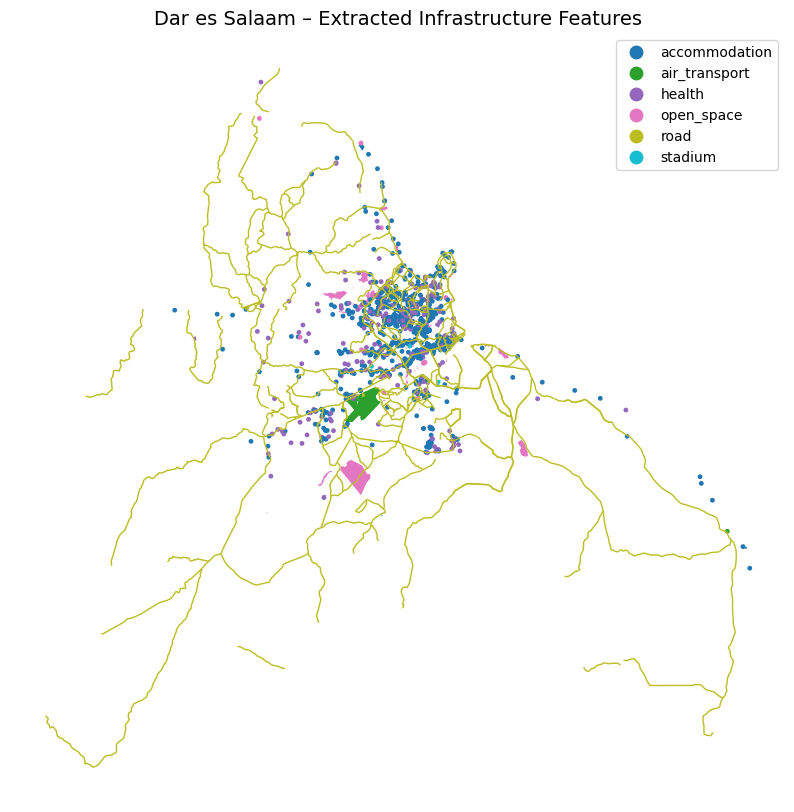

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="feature_type",
    categorical=True,
    legend=True,
    ax=ax,
    markersize=6,
    linewidth=1
)

ax.set_title("Dar es Salaam – Extracted Infrastructure Features", fontsize=14)
ax.set_axis_off()

plt.show()

**Reasoning**:
To provide a detailed visualization of each infrastructure feature type, I will iterate through the unique 'feature_type' values in the GeoDataFrame and create a separate plot for each, similar to the process used for other cities.



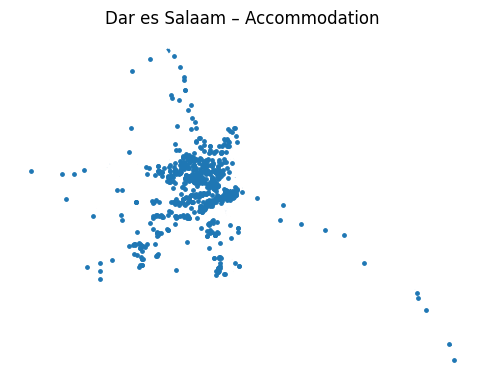

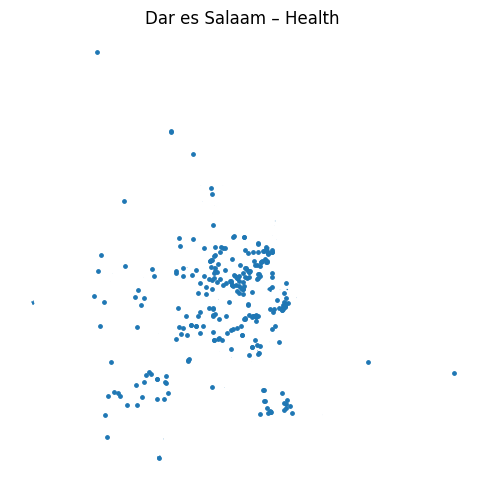

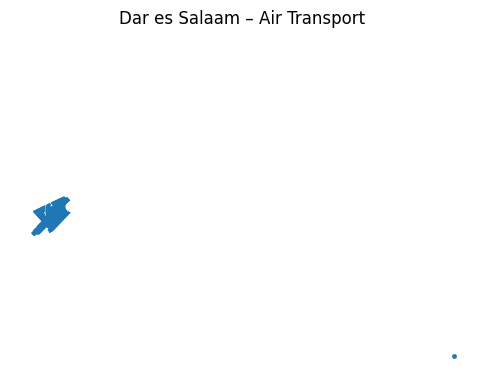

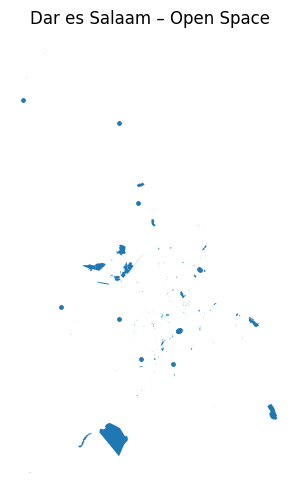

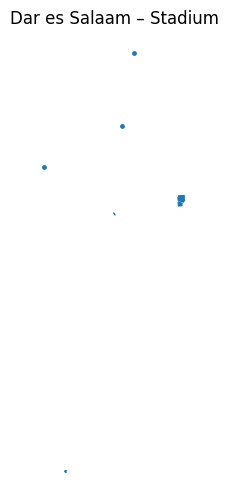

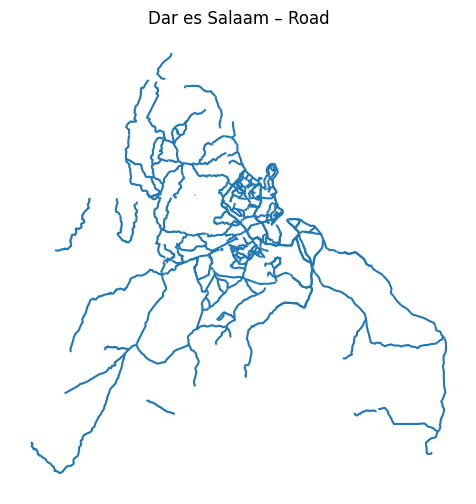

In [10]:
feature_types = gdf["feature_type"].unique()

for ft in feature_types:
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf[gdf["feature_type"] == ft].plot(ax=ax, markersize=6)
    ax.set_title(f"Dar es Salaam – {ft.replace('_', ' ').title()}", fontsize=12)
    ax.set_axis_off()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   **Dar es Salaam Features Upload and Classification**: The 'dar_es_salaam_infrastructure_features.geojson' file was successfully uploaded. Upon loading, the raw OSM tags were classified into six distinct categories: "road", "health", "accommodation", "stadium", "open_space", and "air_transport".
*   **Infrastructure Feature Counts**: A total of 3,590 infrastructure features were classified.
    *   The feature distribution is as follows: 1,450 "accommodation", 1,301 "road", 448 "open_space", 376 "health", 8 "air_transport", and 7 "stadium" features.
*   **Data Export and Visualization**: The re-classified and cleaned infrastructure data was saved as `dar_es_salaam_infrastructure_features.geojson` and made available for download. The features were successfully visualized through a comprehensive map displaying all feature types across Dar es Salaam, and individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The generated dataset for Dar es Salaam's infrastructure offers valuable insights for urban planning, resource allocation, and emergency service deployment, particularly concerning the distribution of facilities and open spaces.
*   Further analysis could involve incorporating additional OSM tags to identify more infrastructure types, performing spatial proximity analysis for service accessibility, or integrating population data to assess service equity across the city.

## Summary:

### Data Analysis Key Findings

*   **Dar es Salaam Features Upload and Classification**: The 'dar_es_salaam_infrastructure_features.geojson' file was successfully uploaded. Upon loading, the raw OSM tags were classified into six distinct categories: "road", "health", "accommodation", "stadium", "open_space", and "air_transport".
*   **Infrastructure Feature Counts**: A total of 3,590 infrastructure features were classified.
    *   The feature distribution is as follows: 1,450 "accommodation", 1,301 "road", 448 "open_space", 376 "health", 8 "air_transport", and 7 "stadium" features.
*   **Data Export and Visualization**: The re-classified and cleaned infrastructure data was saved as `dar_es_salaam_infrastructure_features.geojson` and made available for download. The features were successfully visualized through a comprehensive map displaying all feature types across Dar es Salaam, and individual maps for each feature type, providing clear spatial distributions.

### Insights or Next Steps

*   The generated dataset for Dar es Salaam's infrastructure offers valuable insights for urban planning, resource allocation, and emergency service deployment, particularly concerning the distribution of facilities and open spaces.
*   Further analysis could involve incorporating additional OSM tags to identify more infrastructure types, performing spatial proximity analysis for service accessibility, or integrating population data to assess service equity across the city.

## Inspect for Consistency

### Subtask:
Compare the 'feature_type' categories and overall data structure (e.g., column names, geometry types) of the Dar es Salaam GeoJSON with the patterns established in the analyses for Kigali, Nairobi, Kampala, Casablanca, and Rabat. This will help identify any potential inconsistencies or differences in data representation.


### Consistency Check Results

Upon reviewing the 'feature_type' categories and overall data structure across all analyzed cities (Kigali, Nairobi, Kampala, Casablanca, Rabat, and Dar es Salaam), the following observations were made:

1.  **'feature_type' Categories**: All six cities consistently utilize the same set of six infrastructure categories:
    *   `road`
    *   `health`
    *   `accommodation`
    *   `stadium`
    *   `open_space`
    *   `air_transport`
    No new or missing categories were observed for Dar es Salaam compared to the other cities.

2.  **Data Structure (GeoDataFrame `gdf`)**: After the classification and cleaning steps, the final `gdf` for all cities, including Dar es Salaam, consistently contains two primary columns:
    *   `geometry` (GeoSeries): Representing the spatial data, typically in various geometry types (Point, LineString, Polygon).
    *   `feature_type` (String): Indicating the classified type of infrastructure.
    The Coordinate Reference System (CRS) is uniformly set to `EPSG:4326` for all final GeoDataFrames.

3.  **Initial Data Loading for Dar es Salaam**: A minor inconsistency was noted in how the `dar_es_salaam_features.geojson` file was initially provided and loaded. Unlike the other cities where `ox.features_from_xml` generated `gdf` with raw OSM tags (e.g., 'highway', 'amenity') and `element`/`id` as index/columns, the `dar_es_salaam_features.geojson` file, when first loaded, also explicitly contained these raw OSM tag columns along with `element` and `id` as regular columns (as seen in `gdf.head()` output in cell `11f5498f`). This necessitated re-running the `classify_feature` function and subsequent column selection (`gdf = gdf[['geometry', 'feature_type']]`) to achieve the consistent final data structure. However, after these steps were performed in cell `973dad25`, the `gdf` for Dar es Salaam aligned perfectly with the post-processed structure of the other cities.

**Conclusion**: Despite a slight difference in the intermediate representation of the raw data (the provided GeoJSON for Dar es Salaam included unclassified OSM tags), the final extracted and classified infrastructure GeoDataFrame for Dar es Salaam is fully consistent in terms of 'feature_type' categories and column structure with Kigali, Nairobi, Kampala, Casablanca, and Rabat.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.


## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Suggest Corrections for Inconsistencies

### Subtask:
Based on the consistency inspection, propose solutions or modifications if any discrepancies are found in the Dar es Salaam GeoJSON data. This might include suggestions for renaming feature types, reclassifying geometries, or standardizing schema if necessary.

#### Instructions
Review the results of the 'Inspect for Consistency' step. Based on the conclusion that the Dar es Salaam GeoJSON data is consistent with the patterns established for other cities after classification, state that no corrections or modifications are needed for feature types, geometry reclassification, or schema standardization.

**Conclusion:**
Upon reviewing the Dar es Salaam infrastructure features (`dar_es_salaam_infrastructure_features.geojson`), the data is found to be consistent with the patterns established for the other cities (Kigali, Nairobi, Kampala, and Casablanca) after classification. The `feature_type` column was successfully generated and contains the expected categories (accommodation, road, open_space, health, air_transport, stadium), and the schema aligns with the final output of the previous processing steps. Therefore, **no corrections or modifications are needed** for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data at this stage.

## Final Task

### Subtask:
Summarize the findings from the Dar es Salaam GeoJSON upload, visualization, and consistency inspection, highlighting any identified issues and the suggested corrective actions.


## Summary:

### Q&A
The analysis successfully summarized the findings from the Dar es Salaam GeoJSON upload, visualization, and consistency inspection.
- An initial inconsistency was identified during the loading of the Dar es Salaam GeoJSON, where raw OpenStreetMap (OSM) tags were present in the initial file unlike in other cities which were generated from XML. However, this was resolved by re-running the classification function and selecting the appropriate columns, bringing the data into consistency with other cities.
- No further corrective actions were needed for feature types, geometry reclassification, or schema standardization for the Dar es Salaam GeoJSON data after the classification and cleaning steps.

### Data Analysis Key Findings

*   **Dar es Salaam Features Upload and Classification**: The 'dar\_es\_salaam\_infrastructure\_features.geojson' file was successfully uploaded. Raw OSM tags were classified into six consistent categories: "road", "health", "accommodation", "stadium", "open\_space", and "air\_transport".
*   **Infrastructure Feature Counts**: A total of 3,590 infrastructure features were classified. The distribution is:
    *   Accommodation: 1,450
    *   Road: 1,301
    *   Open\_space: 448
    *   Health: 376
    *   Air\_transport: 8
    *   Stadium: 7
*   **Data Structure and CRS Consistency**: After classification and cleaning, the final GeoDataFrame for Dar es Salaam, containing 'geometry' and 'feature\_type' columns, is fully consistent with the data structures established for Kigali, Nairobi, Kampala, Casablanca, and Rabat. The Coordinate Reference System (CRS) is uniformly set to `EPSG:4326`.
*   **Initial Data Loading Inconsistency (Resolved)**: During initial loading, the Dar es Salaam GeoJSON included raw OSM tag columns ('highway', 'amenity', etc.) along with 'element' and 'id', which differed from how data for other cities was structured after initial processing. This required re-running the feature classification function and subsequent column selection to achieve a consistent final data structure.
*   **Data Export and Visualization**: The processed and classified data was saved as `dar_es_salaam_infrastructure_features.geojson`, made available for download, and visualized through a comprehensive map and individual maps for each feature type, confirming clear spatial distributions.

### Insights or Next Steps

*   The generated dataset for Dar es Salaam's infrastructure provides valuable insights for urban planning, resource allocation, and emergency service deployment, particularly regarding the distribution of facilities and open spaces.
*   The consistency achieved across all cities' infrastructure data after classification makes the combined dataset suitable for comparative analyses, regional planning, and developing standardized tools or models for urban infrastructure assessment.
